In [1]:
import geopandas as gpd
from rasterstats import zonal_stats

# Load the shapefile containing city polygons.
cities = gpd.read_file("input/Morphological_Urban_Area_SSP_all.shp")

# Path to your LCZ raster exported from GEE (e.g., a GeoTIFF file).
lcz_raster = "input/lcz_v3.tif"

# Compute zonal statistics for each polygon in the cities shapefile.
# The 'categorical=True' option returns a dictionary for each polygon with counts per LCZ value.
stats = zonal_stats(cities, lcz_raster, categorical=True)

# Attach the zonal stats results to the GeoDataFrame.
cities['lcz_stats'] = stats

# Define a function to compute the share of each LCZ type.
def calculate_shares(stat_dict):
    total = sum(stat_dict.values())
    if total == 0:
        return {}
    # Compute the share (as a fraction) for each LCZ class.
    return {lcz: count / total for lcz, count in stat_dict.items()}

# Apply the function to calculate LCZ shares for each city.
cities['lcz_shares'] = cities['lcz_stats'].apply(calculate_shares)

print(cities.head())


   OBJECTID  FID_1                         Aggname        Area     X2016  \
0         1    1.0                        Winnipeg  476.219088   765.850   
1         2    2.0                         Calabar  141.186185   487.705   
2         3    3.0                           Anqiu  142.614875   522.101   
3         4    4.0                         Maracay  337.575116  1186.158   
4         6    6.0  Tel Aviv-Yafo (Tel Aviv-Jaffa)  783.070329  3661.189   

   Cntry_C                                 Cntry__     Shape_Leng  \
0    124.0                                  Canada  383225.072805   
1    566.0                                 Nigeria   92047.866192   
2    156.0                                   China   85910.670217   
3    862.0  Venezuela (Bolivarian Republic of)\r\n  124586.331505   
4    376.0                                  Israel  228415.427916   

     Shape_Area        ZS_sum  ...    SSP5_2070s    SSP5_2100s    SSP3_2020s  \
0  4.762191e+08  6.869692e+05  ...  1.418474e+06

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_2314/477638989.py:62: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  [city.geometry.unary_union],
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_2314/477638989.py:62: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  [city.geometry.unary_union],
/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_2314/477638989.py:62: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  [city.geometry.unary_union],


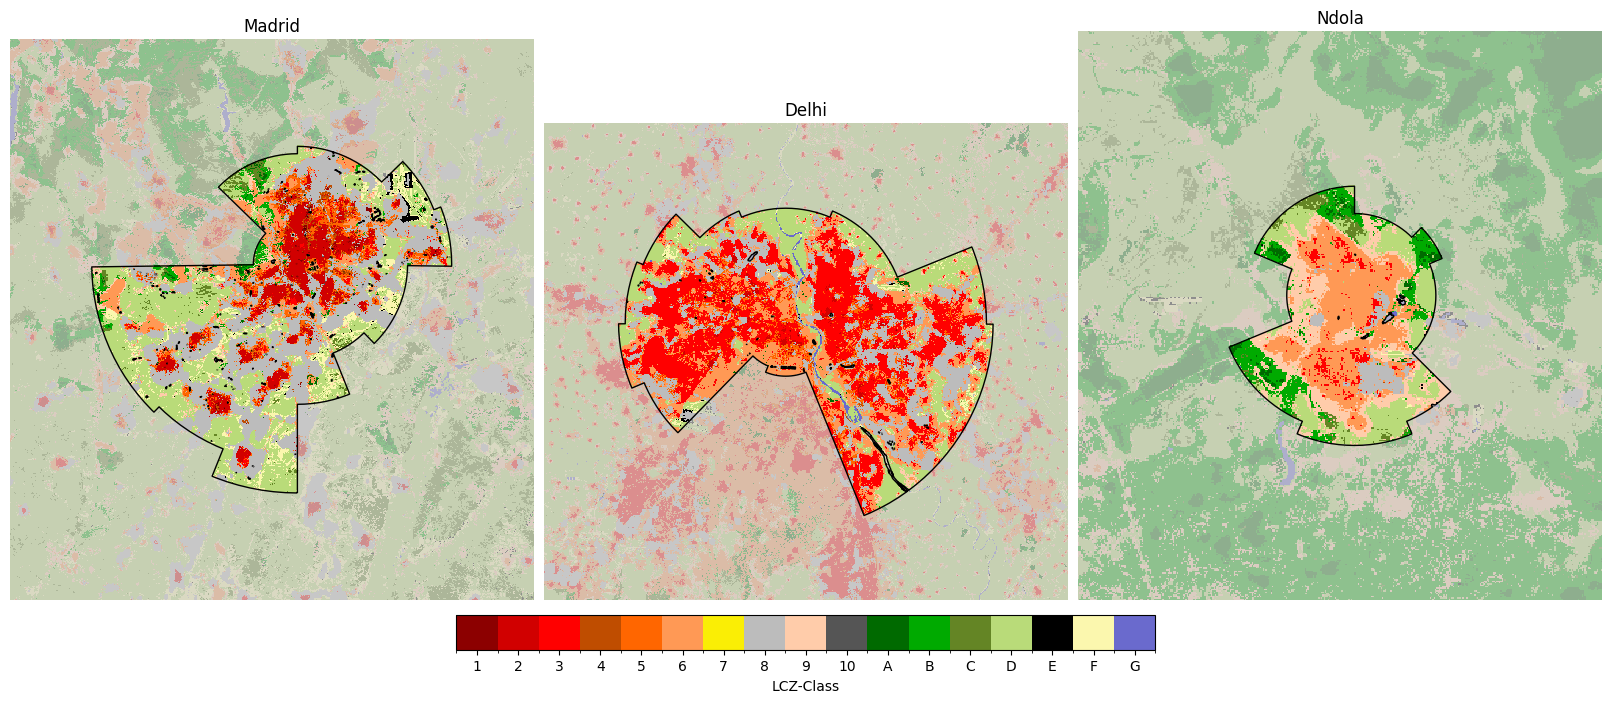

In [2]:
import geopandas as gpd
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# 0) Deine RGBA‑Werte für LCZ 1–17 (R, G, B, A jeweils 0–255)
rgba_vals = {
    1:  (140,   0,   0, 255),
    2:  (209,   0,   0, 255),
    3:  (255,   0,   0, 255),
    4:  (191,  77,   0, 255),
    5:  (255, 102,   0, 255),
    6:  (255, 153,  85, 255),
    7:  (250, 238,   5, 255),
    8:  (188, 188, 188, 255),
    9:  (255, 204, 170, 255),
    10: ( 85,  85,  85, 255),
    11: (  0, 106,   0, 255),
    12: (  0, 170,   0, 255),
    13: (100, 133,  37, 255),
    14: (185, 219, 121, 255),
    15: (  0,   0,   0, 255),
    16: (251, 247, 174, 255),
    17: (106, 106, 205, 255)
}

# Normalisiere auf [0,1] und baue die Colormap-Liste
colors = [
    tuple(val/255 for val in rgba_vals[i])
    for i in range(1, 18)
]
lcmap = ListedColormap(colors, name="LCZ_custom")
# Jede Klasse liegt bei ihrem Integer. Grenzen daher 0.5–17.5
lnorm = BoundaryNorm(boundaries=np.arange(0.5, 18.5, 1), ncolors=17)

# 1) Städte laden & reprojizieren
cities = gpd.read_file("input/Morphological_Urban_Area_SSP_all.shp")
with rasterio.open("input/lcz_v3.tif") as src:
    raster_crs = src.crs
cities = cities.to_crs(raster_crs)

# 2) Subplots für Delhi & Madrid
fig, axes = plt.subplots(1, 3, figsize=(16, 8), constrained_layout=True)

for ax, city_name in zip(axes, ["Madrid", "Delhi", "Ndola"]): #Delhi
    city = cities[cities['Aggname'] == city_name]
    minx, miny, maxx, maxy = city.total_bounds
    pad = 0.1
    bounds = (minx-pad, miny-pad, maxx+pad, maxy+pad)

    # 3) LCZ‑Fenster einlesen
    with rasterio.open("input/lcz_v3.tif") as src:
        window = from_bounds(*bounds, transform=src.transform)
        img = src.read(1, window=window)
        win_transform = src.window_transform(window)

    # 4) Außen‑Maske erzeugen
    mask_outside = geometry_mask(
        [city.geometry.unary_union],
        transform=win_transform,
        invert=False,
        out_shape=img.shape
    )

    # 5) LCZ‑Raster mit deiner Colormap plotten
    im = ax.imshow(
        img,
        cmap=lcmap,
        norm=lnorm,
        extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
        interpolation="none"
    )

    # 6) RGBA‑Overlay außerhalb
    h, w = img.shape
    overlay = np.zeros((h, w, 4), dtype=float)
    # nur außerhalb: hier leichtes Hellgrau + 70% Deckkraft
    overlay[mask_outside, :3] = 0.8
    overlay[mask_outside,  3]    = 0.7
    ax.imshow(
        overlay,
        extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
        interpolation="none"
    )

    # 7) Stadtgrenze drauf
    city.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
    ax.set_title(city_name)
    ax.set_axis_off()

# 8) Farbskala mit Klassen 1–17
#cbar = fig.colorbar(im, ax=axes, orientation="horizontal",
#                    fraction=0.05, pad=0.02, ticks=range(1,18))
#cbar.set_label("LCZ-Class")
#cbar.set_ticklabels(range(1,18))
cbar = fig.colorbar(im, ax=axes, orientation="horizontal",
                    fraction=0.05, pad=0.02, ticks=range(1,18))
labels = [str(i) for i in range(1, 11)] + list("ABCDEFG")
cbar.set_label("LCZ-Class")
cbar.set_ticklabels(labels)

plt.show()


plt.show()


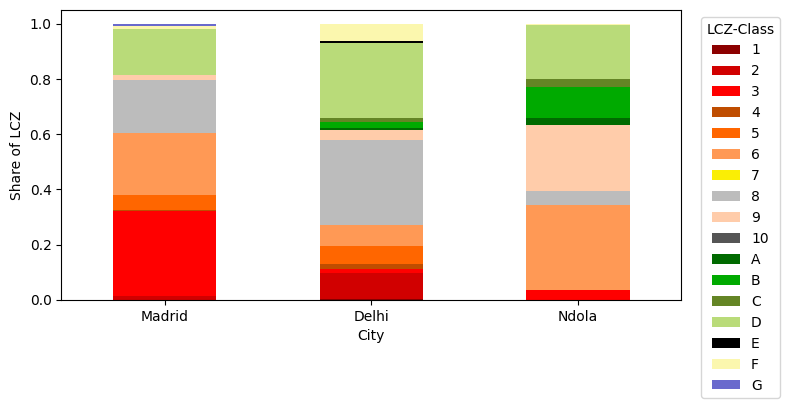

In [3]:
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt

# 1) Deine Städte
city_names = ["Madrid","Delhi" ,"Ndola"]  # oder die tatsächlichen Stadtnamen

# 2) Zonal stats für LCZ‑Raster
stats = zonal_stats(
    cities[cities["Aggname"].isin(city_names)],
    "input/lcz_v3.tif",
    categorical=True
)
df_counts = pd.DataFrame(stats, index=city_names)

# 3) Sicherstellen, dass alle Klassen 1–17 vorhanden sind
for cls in range(1, 18):
    if cls not in df_counts.columns:
        df_counts[cls] = 0
df_counts = df_counts[sorted(df_counts.columns)]

# 4) Anteils‑DataFrame
df_shares = df_counts.div(df_counts.sum(axis=1), axis=0)

# 5) Spalten 11–17 in A–G umbenennen
label_map = {i: str(i) for i in range(1, 11)}
label_map.update({11: "A", 12: "B", 13: "C", 14: "D", 15: "E", 16: "F", 17: "G"})
df_shares = df_shares.rename(columns=label_map)

# 6) Farbpalette in gleicher Reihenfolge wie die umbenannten Spalten
rgba_vals = {
    1:  (140,   0,   0),
    2:  (209,   0,   0),
    3:  (255,   0,   0),
    4:  (191,  77,   0),
    5:  (255, 102,   0),
    6:  (255, 153,  85),
    7:  (250, 238,   5),
    8:  (188, 188, 188),
    9:  (255, 204, 170),
    10: ( 85,  85,  85),
    11: (  0, 106,   0),
    12: (  0, 170,   0),
    13: (100, 133,  37),
    14: (185, 219, 121),
    15: (  0,   0,   0),
    16: (251, 247, 174),
    17: (106, 106, 205)
}
share_colors = []
for col in df_shares.columns:
    # alphanumerisch sortierte labels: '1','10',...,'17','2',...
    # wir mappen sie zurück auf Integer
    int_key = int(col) if col.isdigit() else ord(col) - ord("A") + 11
    rgb = rgba_vals[int_key]
    share_colors.append((rgb[0]/255, rgb[1]/255, rgb[2]/255))

# 7) Gestapeltes Balkendiagramm
fig, ax = plt.subplots(figsize=(8, 4))
df_shares.plot(
    kind="bar",
    stacked=True,
    color=share_colors,
    ax=ax
)

ax.set_ylabel("Share of LCZ")
ax.set_xlabel("City")
ax.set_xticklabels(city_names, rotation=0)
ax.legend(title="LCZ-Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [1]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats

# Load the shapefile containing city polygons.
cities = gpd.read_file("input/Morphological_Urban_Area_SSP_all.shp")

# Path to your LCZ raster exported from GEE (e.g., a GeoTIFF file).
lcz_raster = "input/lcz_v3.tif"

# Compute zonal statistics for each polygon.
# The 'categorical=True' option returns a dictionary for each polygon with counts per LCZ value.
stats = zonal_stats(cities, lcz_raster, categorical=True)
cities['lcz_stats'] = stats

# Define a function to compute the share of each LCZ type.
def calculate_shares(stat_dict):
    total = sum(stat_dict.values())
    if total == 0:
        return {}
    # Compute the share (fraction) for each LCZ class.
    return {lcz: count / total for lcz, count in stat_dict.items()}

# Apply the function to calculate LCZ shares for each city and store the result in a new column.
cities['lcz_shares'] = cities['lcz_stats'].apply(calculate_shares)

# Rename the column "Aggname" to "City".
cities = cities.rename(columns={"Aggname": "City"})

# Expand the dictionary in 'lcz_shares' into separate columns.
# This will create one column per LCZ class. Here we prefix the columns with "LCZ_".
lcz_shares_df = cities['lcz_shares'].apply(pd.Series).add_prefix("LCZ_")
cities = cities.join(lcz_shares_df)

# Read in the CSV file containing additional temperature development data.
temp_data = pd.read_csv("cities_temp_diff_data_SSP5.csv")



# Merge the temperature data with the cities GeoDataFrame on the "City" column.
merged_data = cities.merge(temp_data, on="City", how="left")

# Display the first few rows of the merged DataFrame.
print(merged_data.head())

# Optionally, export the merged data to CSV (dropping the geometry column if not needed).
merged_data.drop(columns='geometry').to_csv("output/merged_data.csv", index=False)


KeyboardInterrupt: 

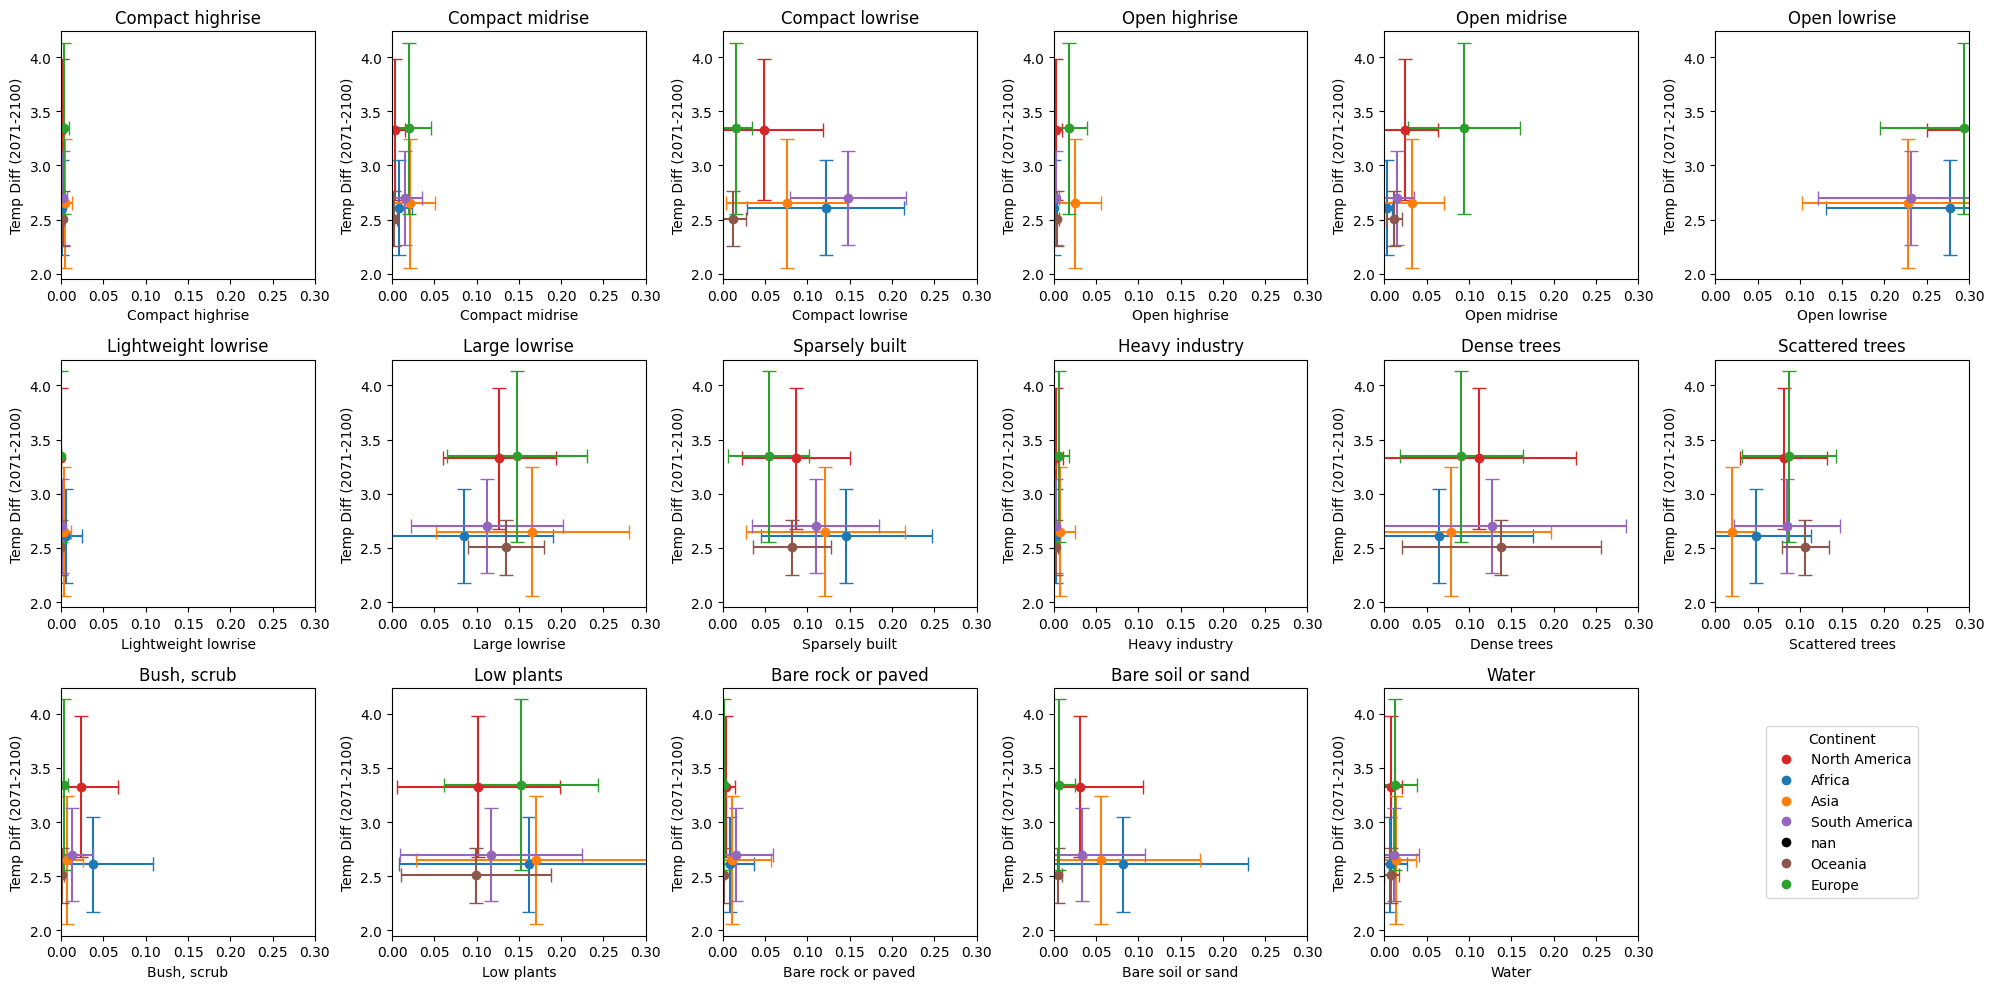

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# If not already loaded, load the merged data:
# merged_data = pd.read_csv("output/merged_data.csv")

# Define LCZ columns (assumed to be named LCZ_1, LCZ_2, ..., LCZ_17)
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]

# Mapping from LCZ column names to descriptive labels.
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define the continent color palette.
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Use the provided palette as the color mapping.
color_mapping = continent_palette

# Get unique continents present in the data.
continents = merged_data['Continent'].unique()

# Create a 3x6 grid of subplots (total 18 subplots).
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
axes = axes.flatten()

# Loop over each LCZ column and create a plot with error bars.
for idx, lcz in enumerate(lcz_columns):
    ax = axes[idx]
    
    # For each continent, calculate the mean and standard deviation.
    for cont in continents:
        subset = merged_data[merged_data['Continent'] == cont]
        mean_x = subset[lcz].mean()
        std_x  = subset[lcz].std()
        mean_y = subset["Temp_Diff_2071_2100"].mean()
        std_y  = subset["Temp_Diff_2071_2100"].std()
        
        # Plot one aggregated point with error bars in both x and y directions.
        ax.errorbar(mean_x, mean_y, xerr=std_x, yerr=std_y, fmt='o',
                    color=color_mapping.get(cont, 'black'), capsize=5, label=cont)
    
    # Set subplot title and x-axis label using the descriptive LCZ name.
    ax.set_title(lcz_labels[lcz])
    ax.set_xlabel(lcz_labels[lcz])
    ax.set_ylabel("Temp Diff (2071-2100)")
    ax.set_xlim(0, 0.3)  # Fix x-axis to range from 0 to 1.

# Use the 18th subplot for the legend.
legend_ax = axes[17]
legend_ax.axis("off")  # Hide axis for legend subplot.

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=color_mapping.get(cont, 'black'),
           markersize=8, label=cont)
    for cont in continents
]

legend_ax.legend(handles=legend_handles, title="Continent", loc="center")

plt.tight_layout()
plt.show()


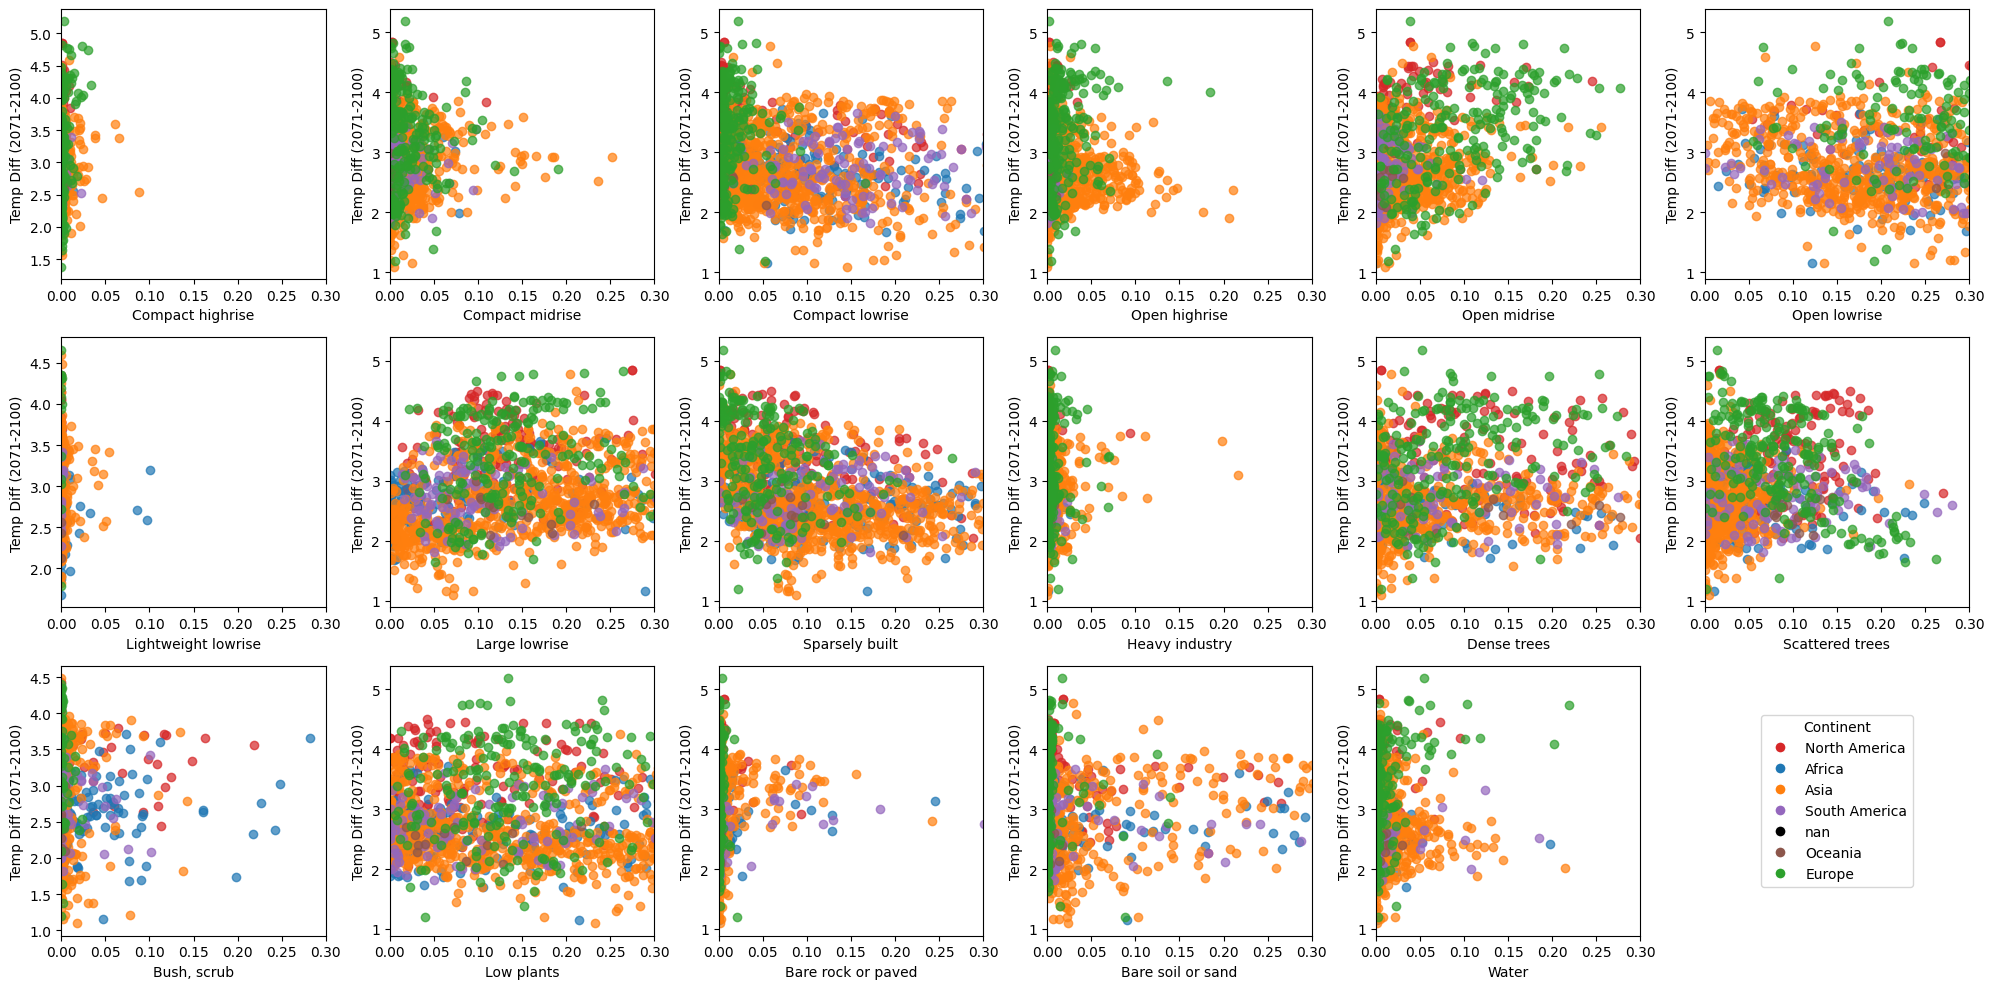

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# If not already loaded, load the merged data:
# merged_data = pd.read_csv("output/merged_data.csv")

# Define LCZ columns (assumed to be named LCZ_1, LCZ_2, ..., LCZ_17)
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]

# Mapping from LCZ column names to descriptive labels.
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define the continent color palette.
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Use the provided palette as the color mapping.
color_mapping = continent_palette

# Get unique continents present in the data.
continents = merged_data['Continent'].unique()

# Create a 3x6 grid of subplots (total 18 subplots).
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
axes = axes.flatten()

# Loop over each LCZ column and create scatter plots.
for idx, lcz in enumerate(lcz_columns):
    ax = axes[idx]
    for cont in continents:
        subset = merged_data[merged_data['Continent'] == cont]
        ax.scatter(
            subset[lcz],
            subset["Temp_Diff_2071_2100"],
            color=color_mapping.get(cont, 'black'),
            alpha=0.7,
            label=cont
        )
    #ax.set_title(lcz_labels[lcz])
    ax.set_xlabel(lcz_labels[lcz])
    ax.set_ylabel("Temp Diff (2071-2100)")
    ax.set_xlim(0, 0.3)  # Ensure x-axis (LCZ share) is fixed between 0 and 1.

# Use the 18th subplot for the legend.
legend_ax = axes[17]
legend_ax.axis("off")  # Hide the axis for the legend.

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=color_mapping.get(cont, 'black'),
           markersize=8, label=cont)
    for cont in continents
]

legend_ax.legend(handles=legend_handles, title="Continent", loc="center")

plt.tight_layout()
plt.show()


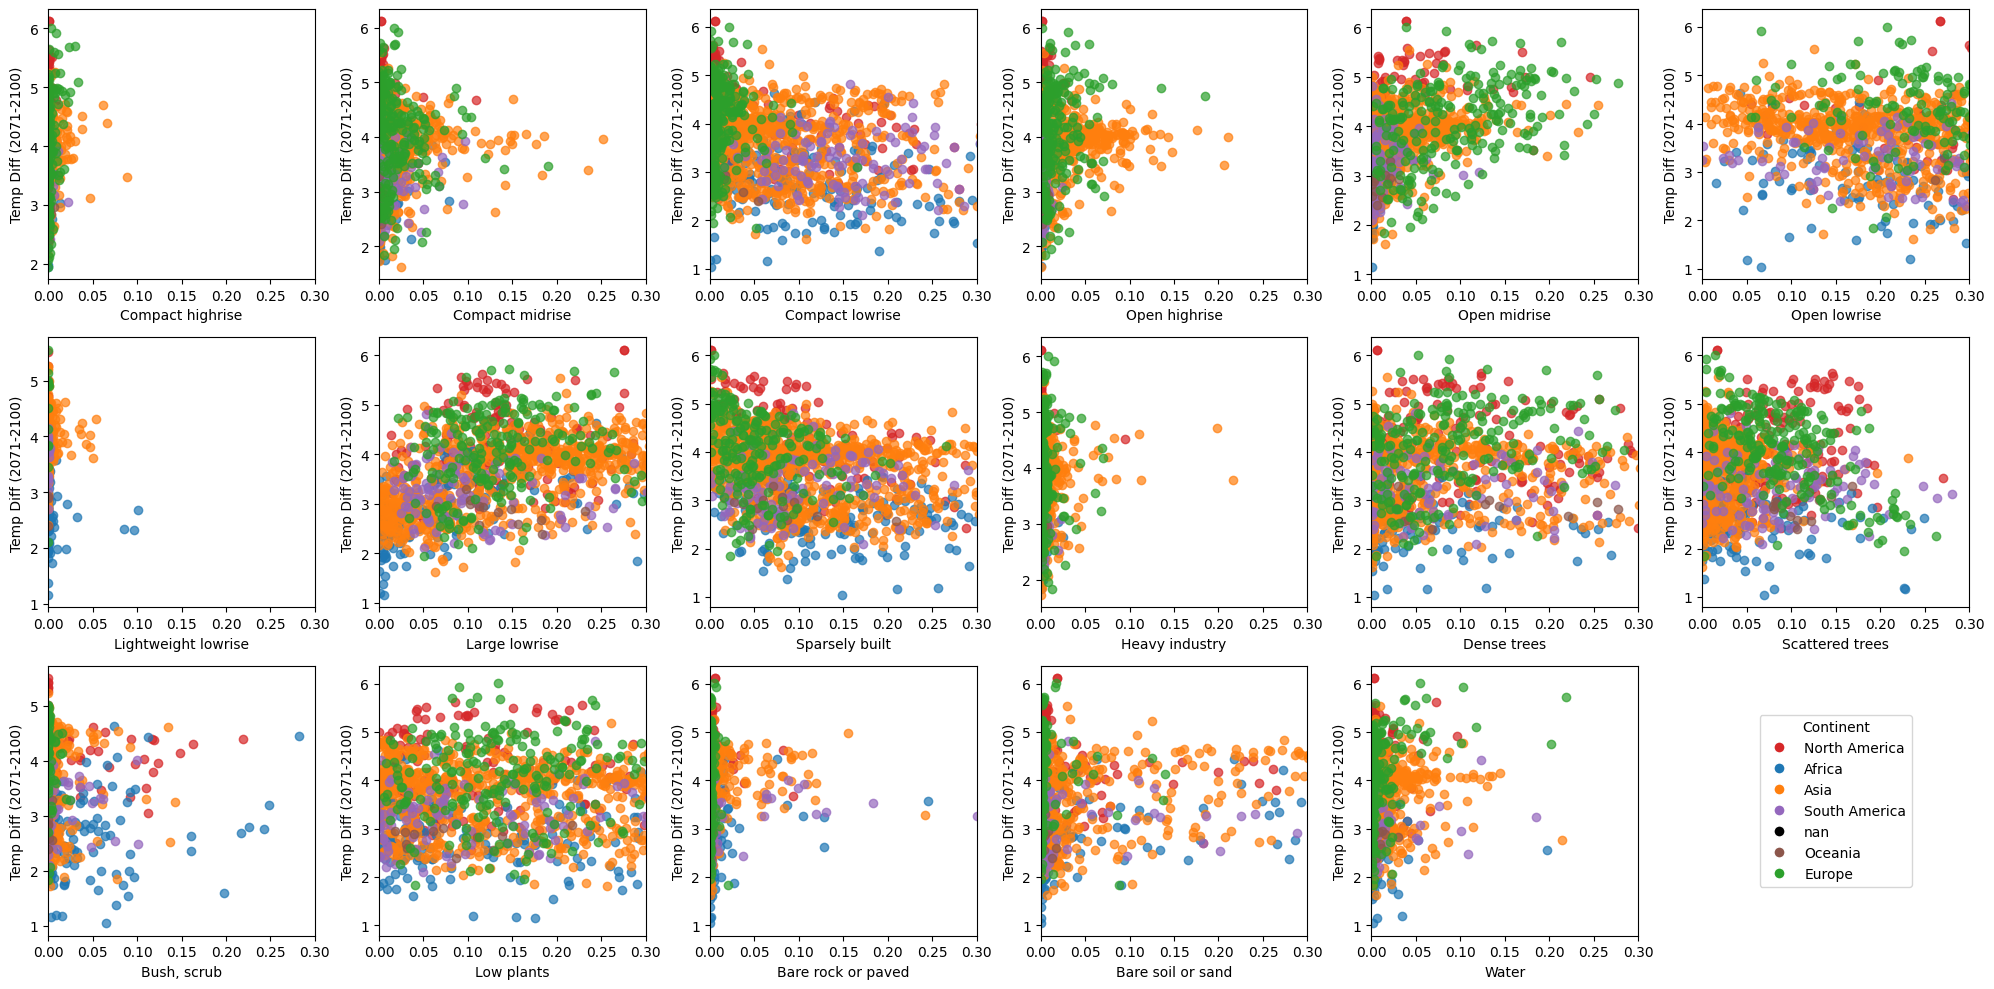

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# If not already loaded, load the merged data:
#merged_data = pd.read_csv("output/merged_data.csv")

# Define LCZ columns (assumed to be named LCZ_1, LCZ_2, ..., LCZ_17)
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]

# Mapping from LCZ column names to descriptive labels.
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define the continent color palette.
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Use the provided palette as the color mapping.
color_mapping = continent_palette

# Get unique continents present in the data.
continents = merged_data['Continent'].unique()

# Create a 3x6 grid of subplots (total 18 subplots).
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
axes = axes.flatten()

# Loop over each LCZ column and create scatter plots.
for idx, lcz in enumerate(lcz_columns):
    ax = axes[idx]
    for cont in continents:
        subset = merged_data[merged_data['Continent'] == cont]
        ax.scatter(
            subset[lcz],
            subset["Temp_Diff_2071_2100"],
            color=color_mapping.get(cont, 'black'),
            alpha=0.7,
            label=cont
        )
    #ax.set_title(lcz_labels[lcz])
    ax.set_xlabel(lcz_labels[lcz])
    ax.set_ylabel("Temp Diff (2071-2100)")
    ax.set_xlim(0, 0.3)  # Ensure x-axis (LCZ share) is fixed between 0 and 1.

# Use the 18th subplot for the legend.
legend_ax = axes[17]
legend_ax.axis("off")  # Hide the axis for the legend.

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=color_mapping.get(cont, 'black'),
           markersize=8, label=cont)
    for cont in continents
]

legend_ax.legend(handles=legend_handles, title="Continent", loc="center")

plt.tight_layout()
plt.show()


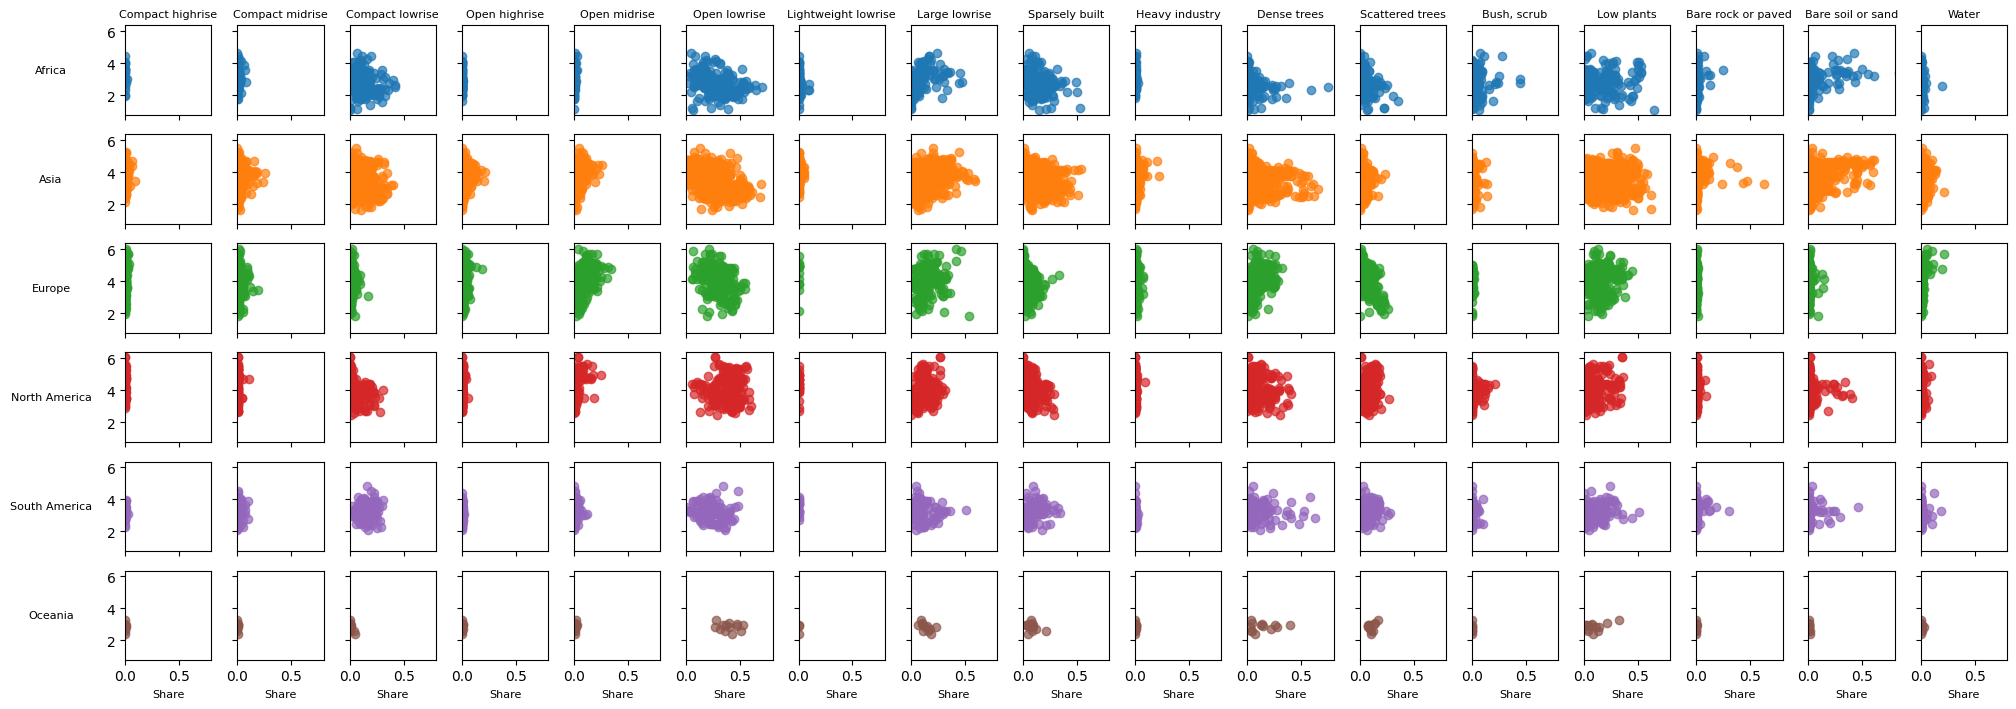

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume merged_data is already loaded and contains:
#  - 'Continent'
#  - 'Temp_Diff_2071_2100'
#  - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define LCZ columns and descriptive labels.
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define continent order and the provided color palette.
continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Create a grid with 6 rows (continents) and 17 columns (LCZ classes).
fig, axes = plt.subplots(nrows=6, ncols=17, figsize=(17*1.2, 6*1.2), sharex=True, sharey=True)

# Loop over each continent (row) and each LCZ (column)
for i, cont in enumerate(continent_order):
    # Filter data for the current continent.
    data_cont = merged_data[merged_data['Continent'] == cont]
    for j, lcz in enumerate(lcz_columns):
        ax = axes[i, j]
        # Filter out NaN values in the LCZ share and Temp_Diff_2071_2100.
        valid = data_cont[lcz].notna() & data_cont["Temp_Diff_2071_2100"].notna()
        x = data_cont.loc[valid, lcz]
        y = data_cont.loc[valid, "Temp_Diff_2071_2100"]
        # Plot the scatter points using the color corresponding to the continent.
        ax.scatter(x, y, color=continent_palette[cont], alpha=0.7)
        ax.set_xlim(0, 0.8)
        
        # For the top row, add LCZ descriptive names as column titles.
        if i == 0:
            ax.set_title(lcz_labels[lcz], fontsize=8)
        # For the left-most column, add the continent name as y-axis label.
        if j == 0:
            ax.set_ylabel(cont, fontsize=8, rotation=0, labelpad=40, va='center')
        # For the bottom row, label the x-axis as "Share".
        if i == 5:
            ax.set_xlabel("Share", fontsize=8)

plt.tight_layout()
plt.show()


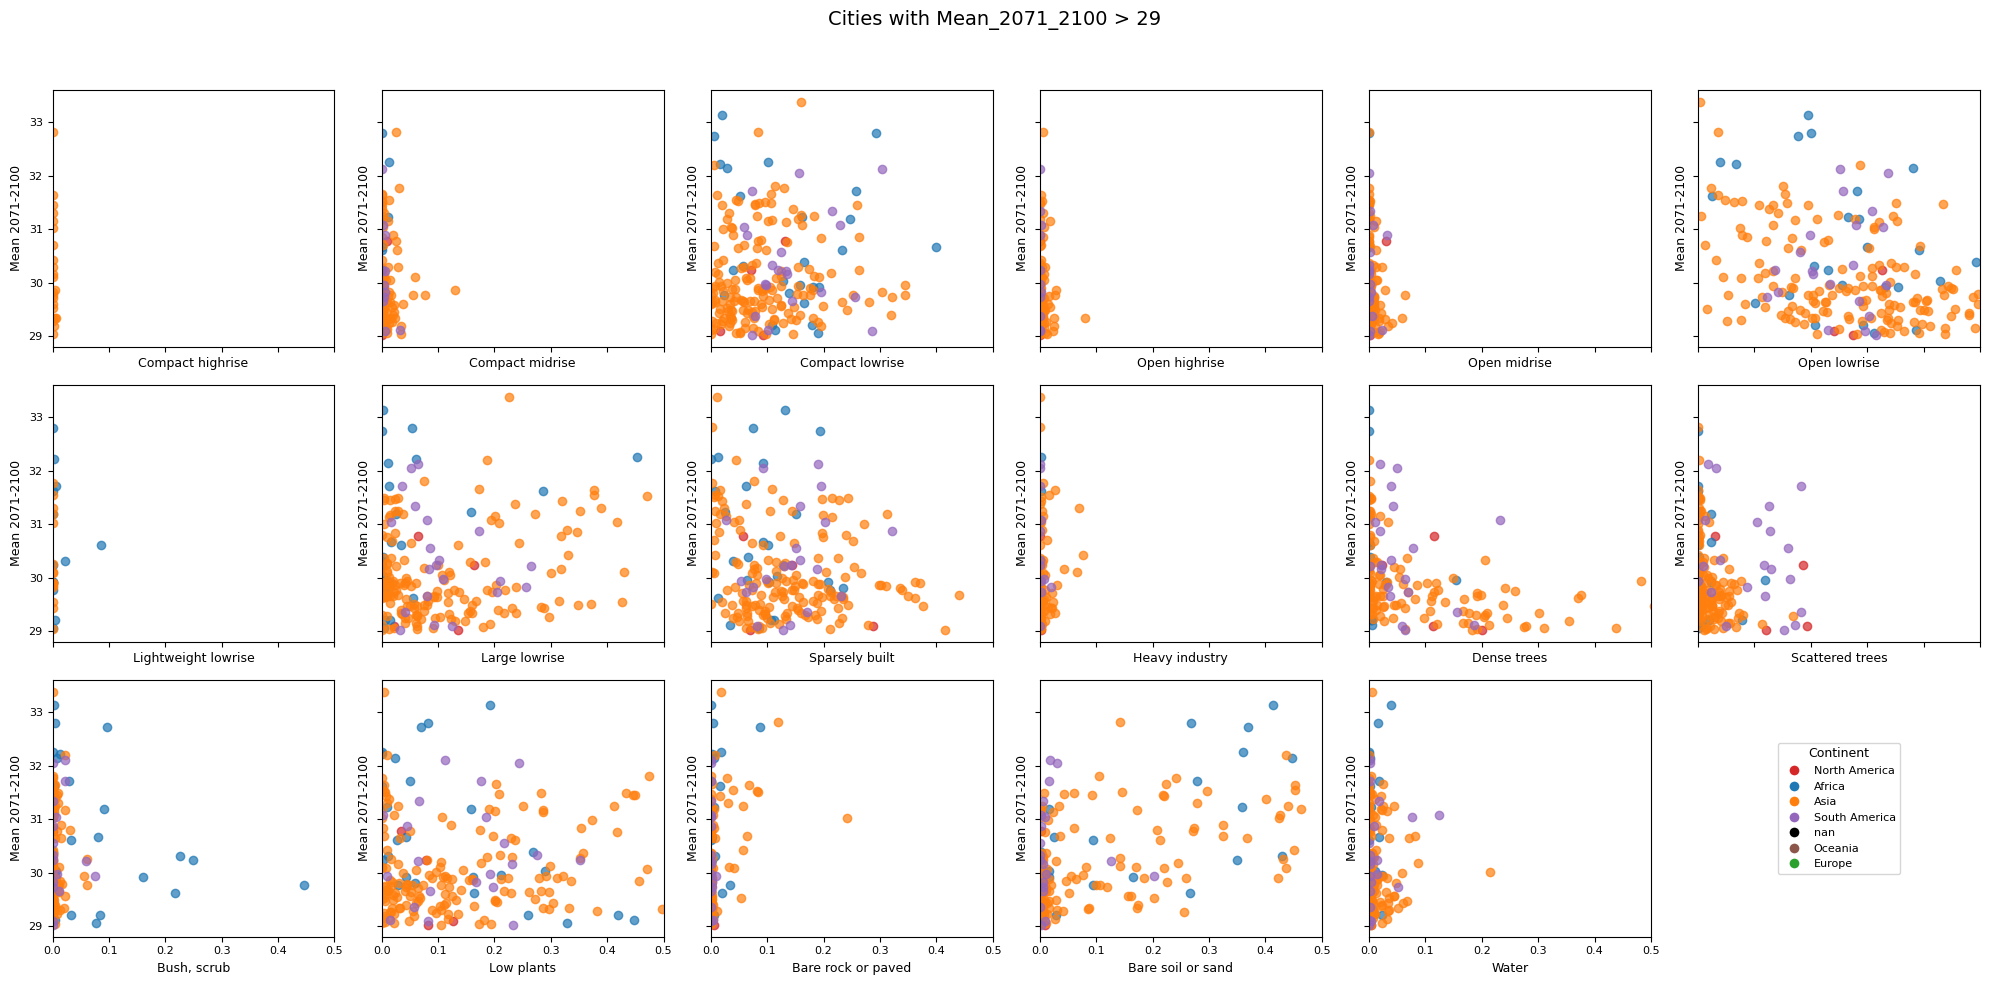

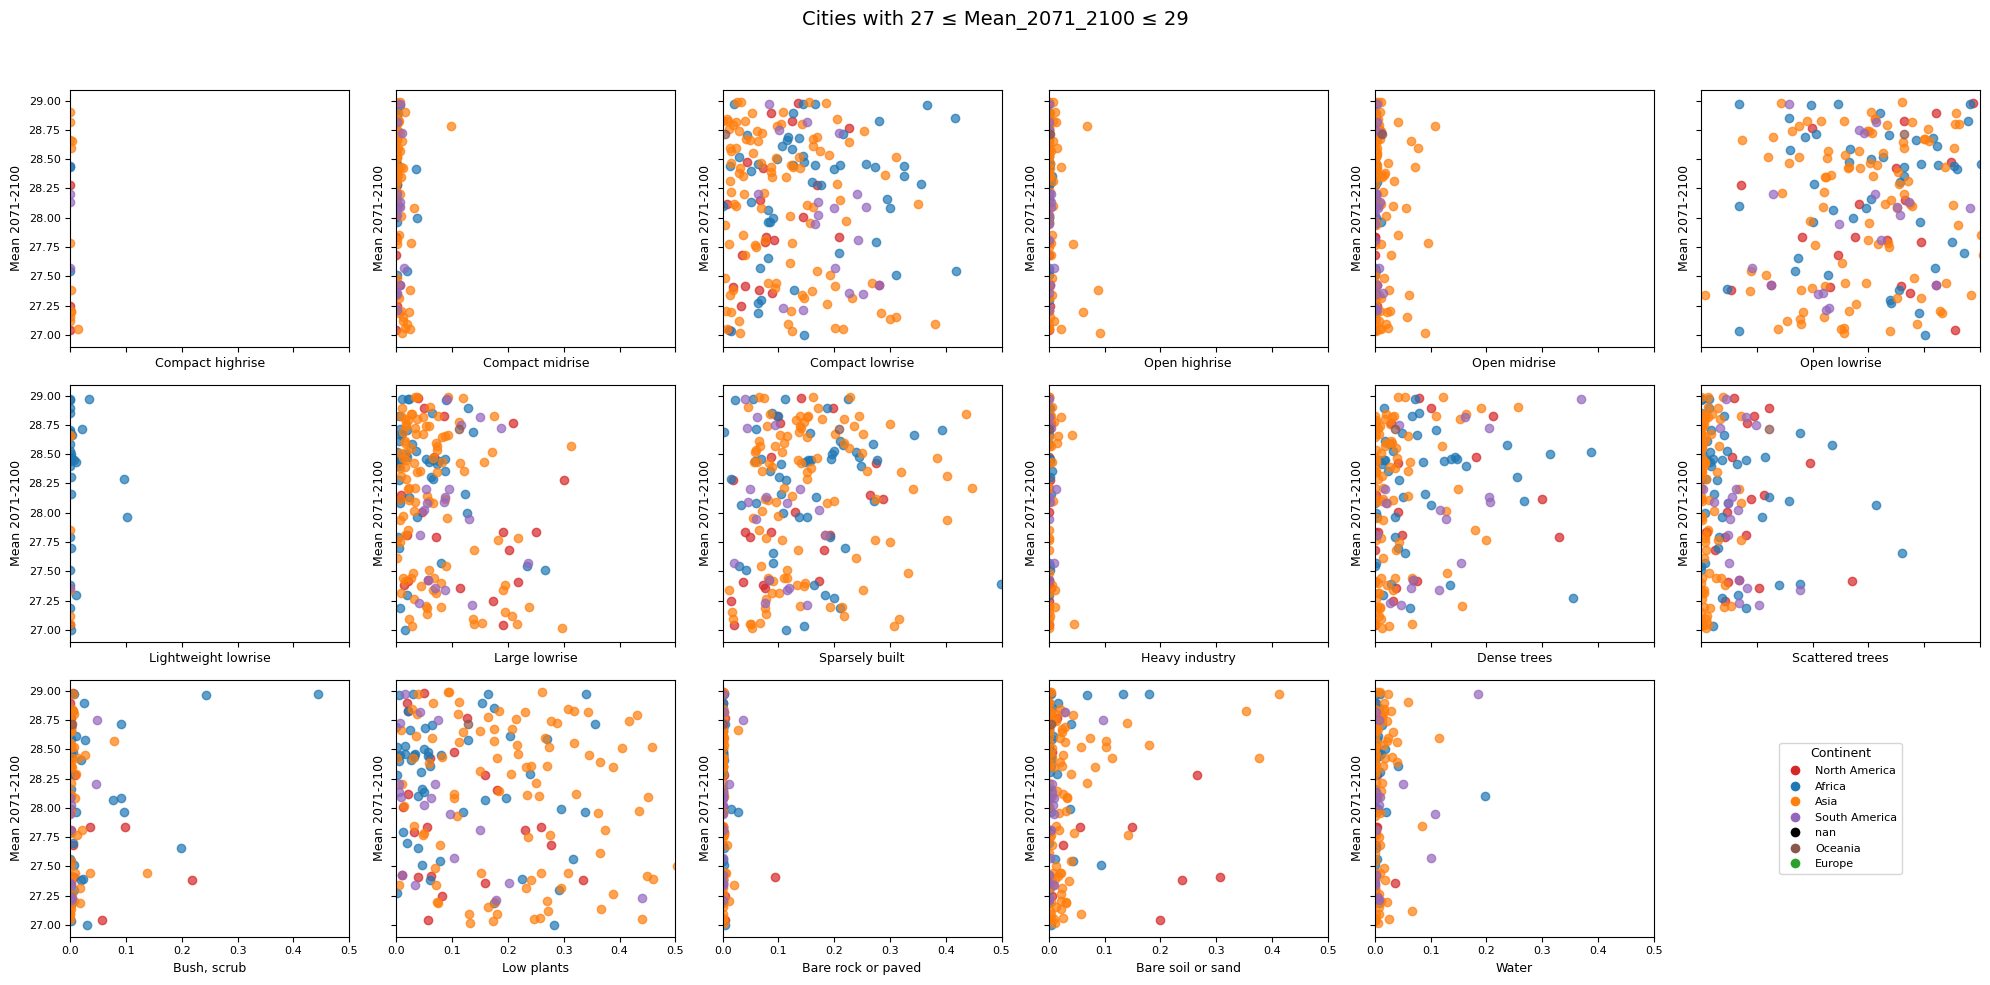

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Assume merged_data is already loaded and contains the following columns:
#   - 'Continent'
#   - 'Mean_2071_2100'
#   - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define LCZ columns and descriptive labels.
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define the continent color palette.
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}
color_mapping = continent_palette

# Get unique continents present in the data.
continents = merged_data['Continent'].unique()

# --- Filter Data by Mean_2071_2100 ---
# Cities with Mean_2071_2100 over 29:
high_cities = merged_data[merged_data["Mean_2071_2100"] > 29]

# Cities with Mean_2071_2100 between 27 and 29:
mid_cities = merged_data[(merged_data["Mean_2071_2100"] >= 27) & (merged_data["Mean_2071_2100"] <= 29)]

# --- Function to Create a Grid of Scatter Plots ---
def plot_lcz_vs_mean(data, title):
    # Create a 3x6 grid of subplots (18 subplots: 17 for LCZ classes, 1 for legend)
    fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, lcz in enumerate(lcz_columns):
        ax = axes[idx]
        # Loop over each continent and plot the cities for that LCZ
        for cont in continents:
            subset = data[data['Continent'] == cont]
            # Plot scatter points: x = LCZ share, y = Mean_2071_2100
            ax.scatter(
                subset[lcz],
                subset["Mean_2071_2100"],
                color=color_mapping.get(cont, 'black'),
                alpha=0.7,
                label=cont
            )
        ax.set_xlabel(lcz_labels[lcz], fontsize=9)
        ax.set_ylabel("Mean 2071-2100", fontsize=9)
        ax.set_xlim(0, 0.5)  # Adjust x-axis limit as needed
        ax.tick_params(labelsize=8)

    # Use the 18th subplot for the legend.
    legend_ax = axes[17]
    legend_ax.axis("off")
    legend_handles = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=color_mapping.get(cont, 'black'),
               markersize=8, label=cont)
        for cont in continents
    ]
    legend_ax.legend(handles=legend_handles, title="Continent", loc="center", fontsize=8, title_fontsize=9)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Plot for Cities with Mean_2071_2100 over 29 ---
plot_lcz_vs_mean(high_cities, "Cities with Mean_2071_2100 > 29")

# --- Plot for Cities with Mean_2071_2100 between 27 and 29 ---
plot_lcz_vs_mean(mid_cities, "Cities with 27 ≤ Mean_2071_2100 ≤ 29")


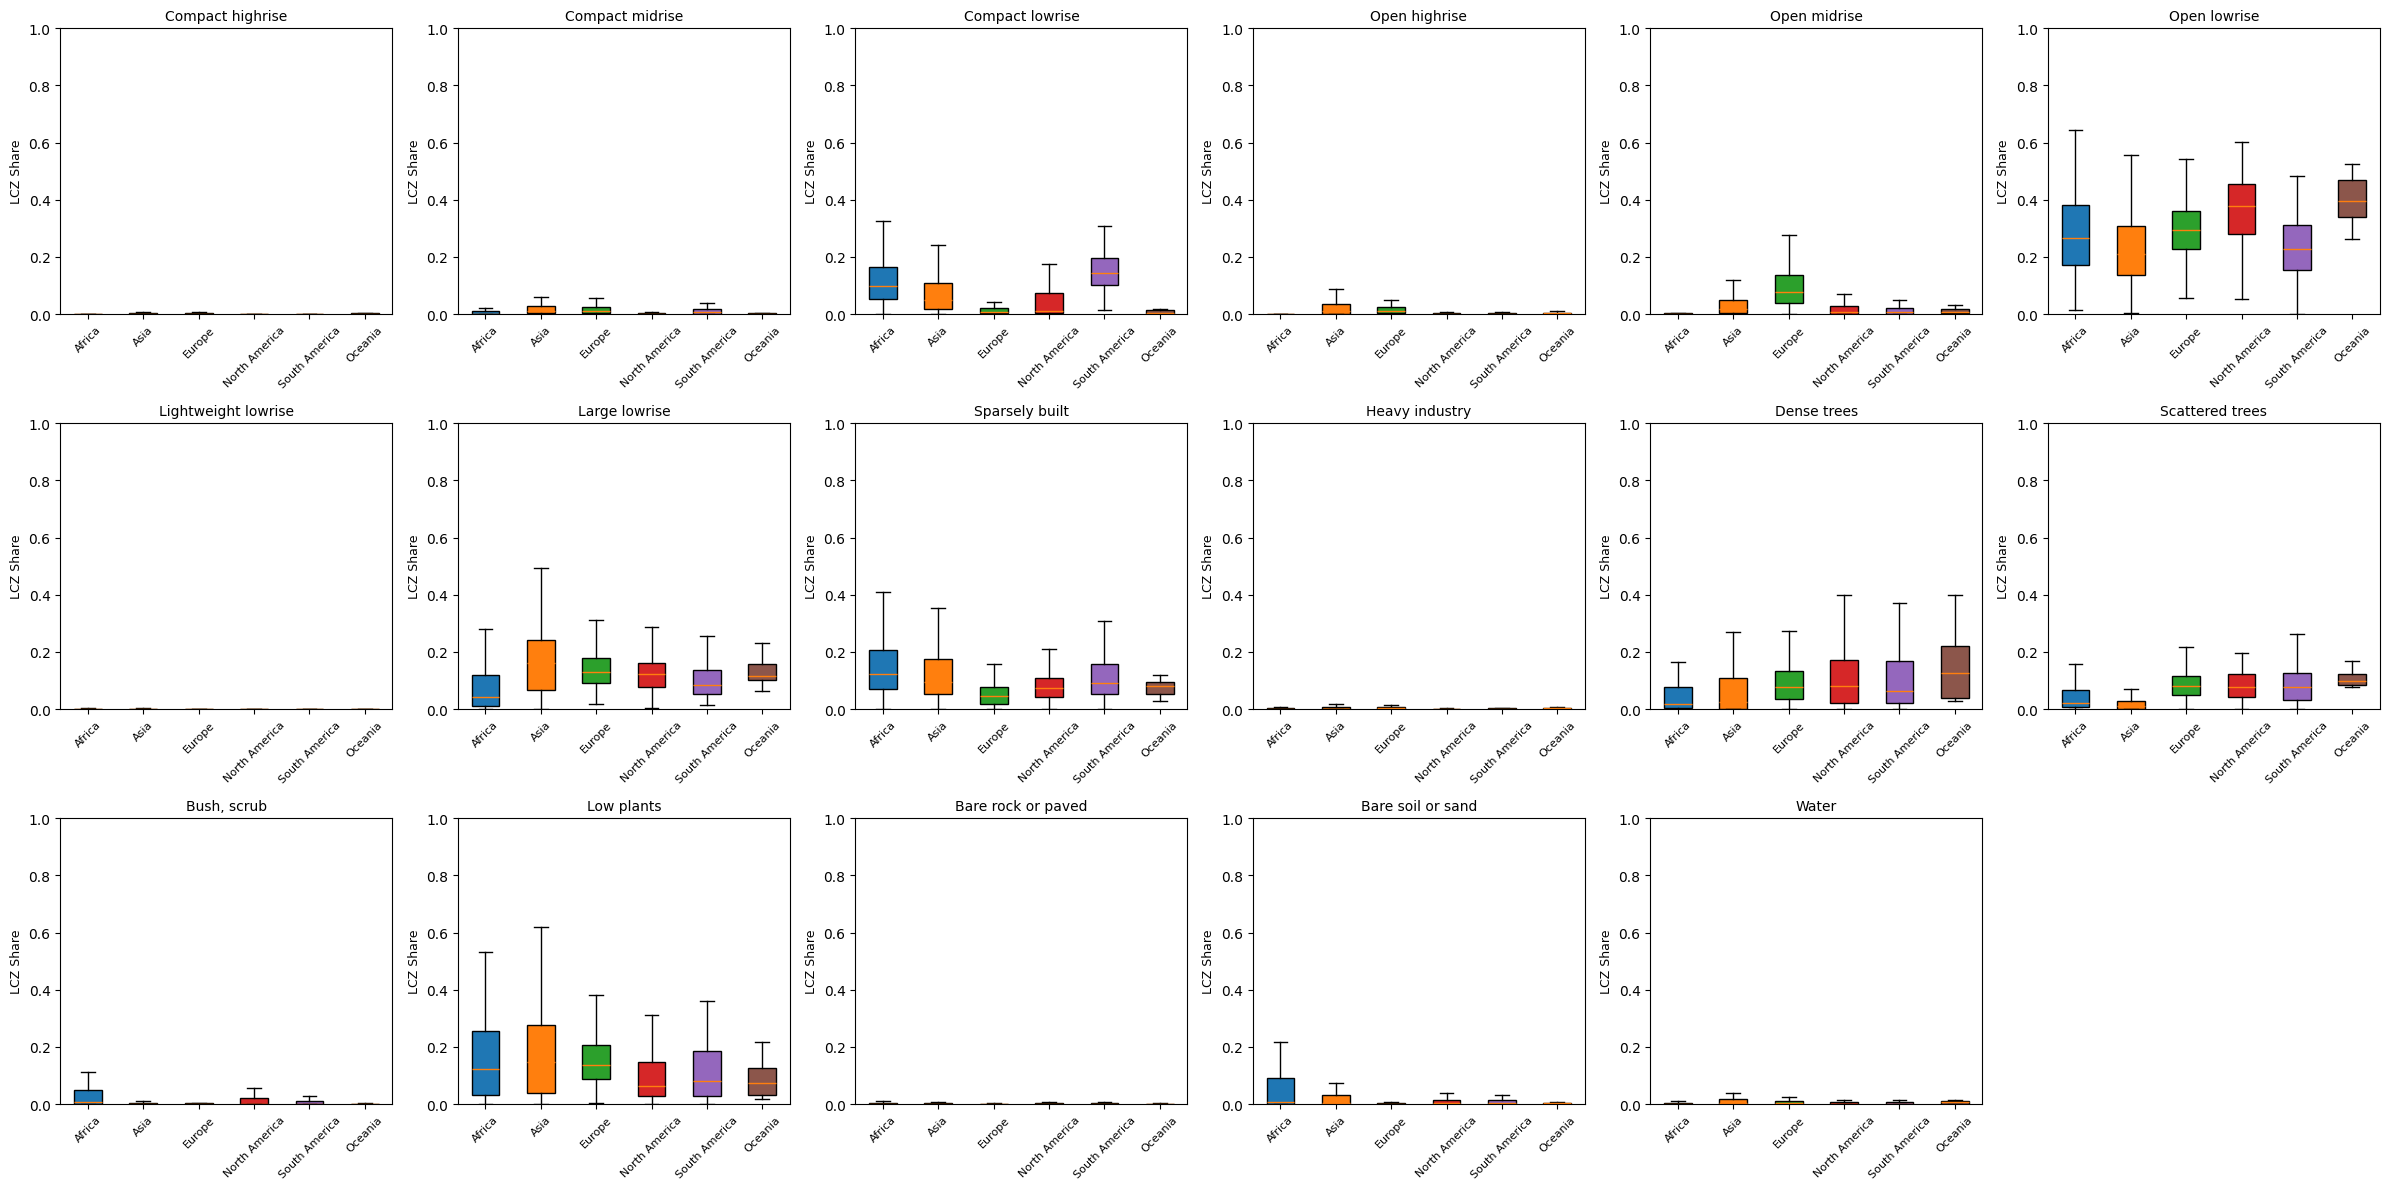

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume merged_data is already loaded and contains:
#  - 'Continent'
#  - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define LCZ columns and descriptive labels.
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define the desired continent order and color palette.
continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Create a grid of subplots.
# We'll arrange them in 3 rows x 6 columns (18 axes) and use only the first 17 for LCZs.
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))
axes = axes.flatten()

# Loop over each LCZ.
for idx, lcz in enumerate(lcz_columns):
    ax = axes[idx]
    # Drop rows with missing values for this LCZ.
    subset = merged_data[['Continent', lcz]].dropna(subset=[lcz])
    
    # Prepare lists for data, labels, and colors.
    data_by_continent = []
    labels = []
    colors = []
    
    # Loop through continents in the defined order.
    for cont in continent_order:
        cont_data = subset[subset['Continent'] == cont][lcz].values
        if len(cont_data) > 0:
            data_by_continent.append(cont_data)
            labels.append(cont)
            colors.append(continent_palette.get(cont, 'black'))
    
    # Plot the box plots if we have any data.
    if data_by_continent:
        bp = ax.boxplot(data_by_continent, positions=range(len(data_by_continent)),
                        patch_artist=True, showfliers=False)
        # Set box colors.
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, fontsize=8)
    
    ax.set_title(lcz_labels[lcz], fontsize=10)
    ax.set_ylabel("LCZ Share", fontsize=9)
    ax.set_ylim(0, 1)

# Hide any unused subplot (e.g. the 18th axis if not needed).
if len(axes) > 17:
    for ax in axes[17:]:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


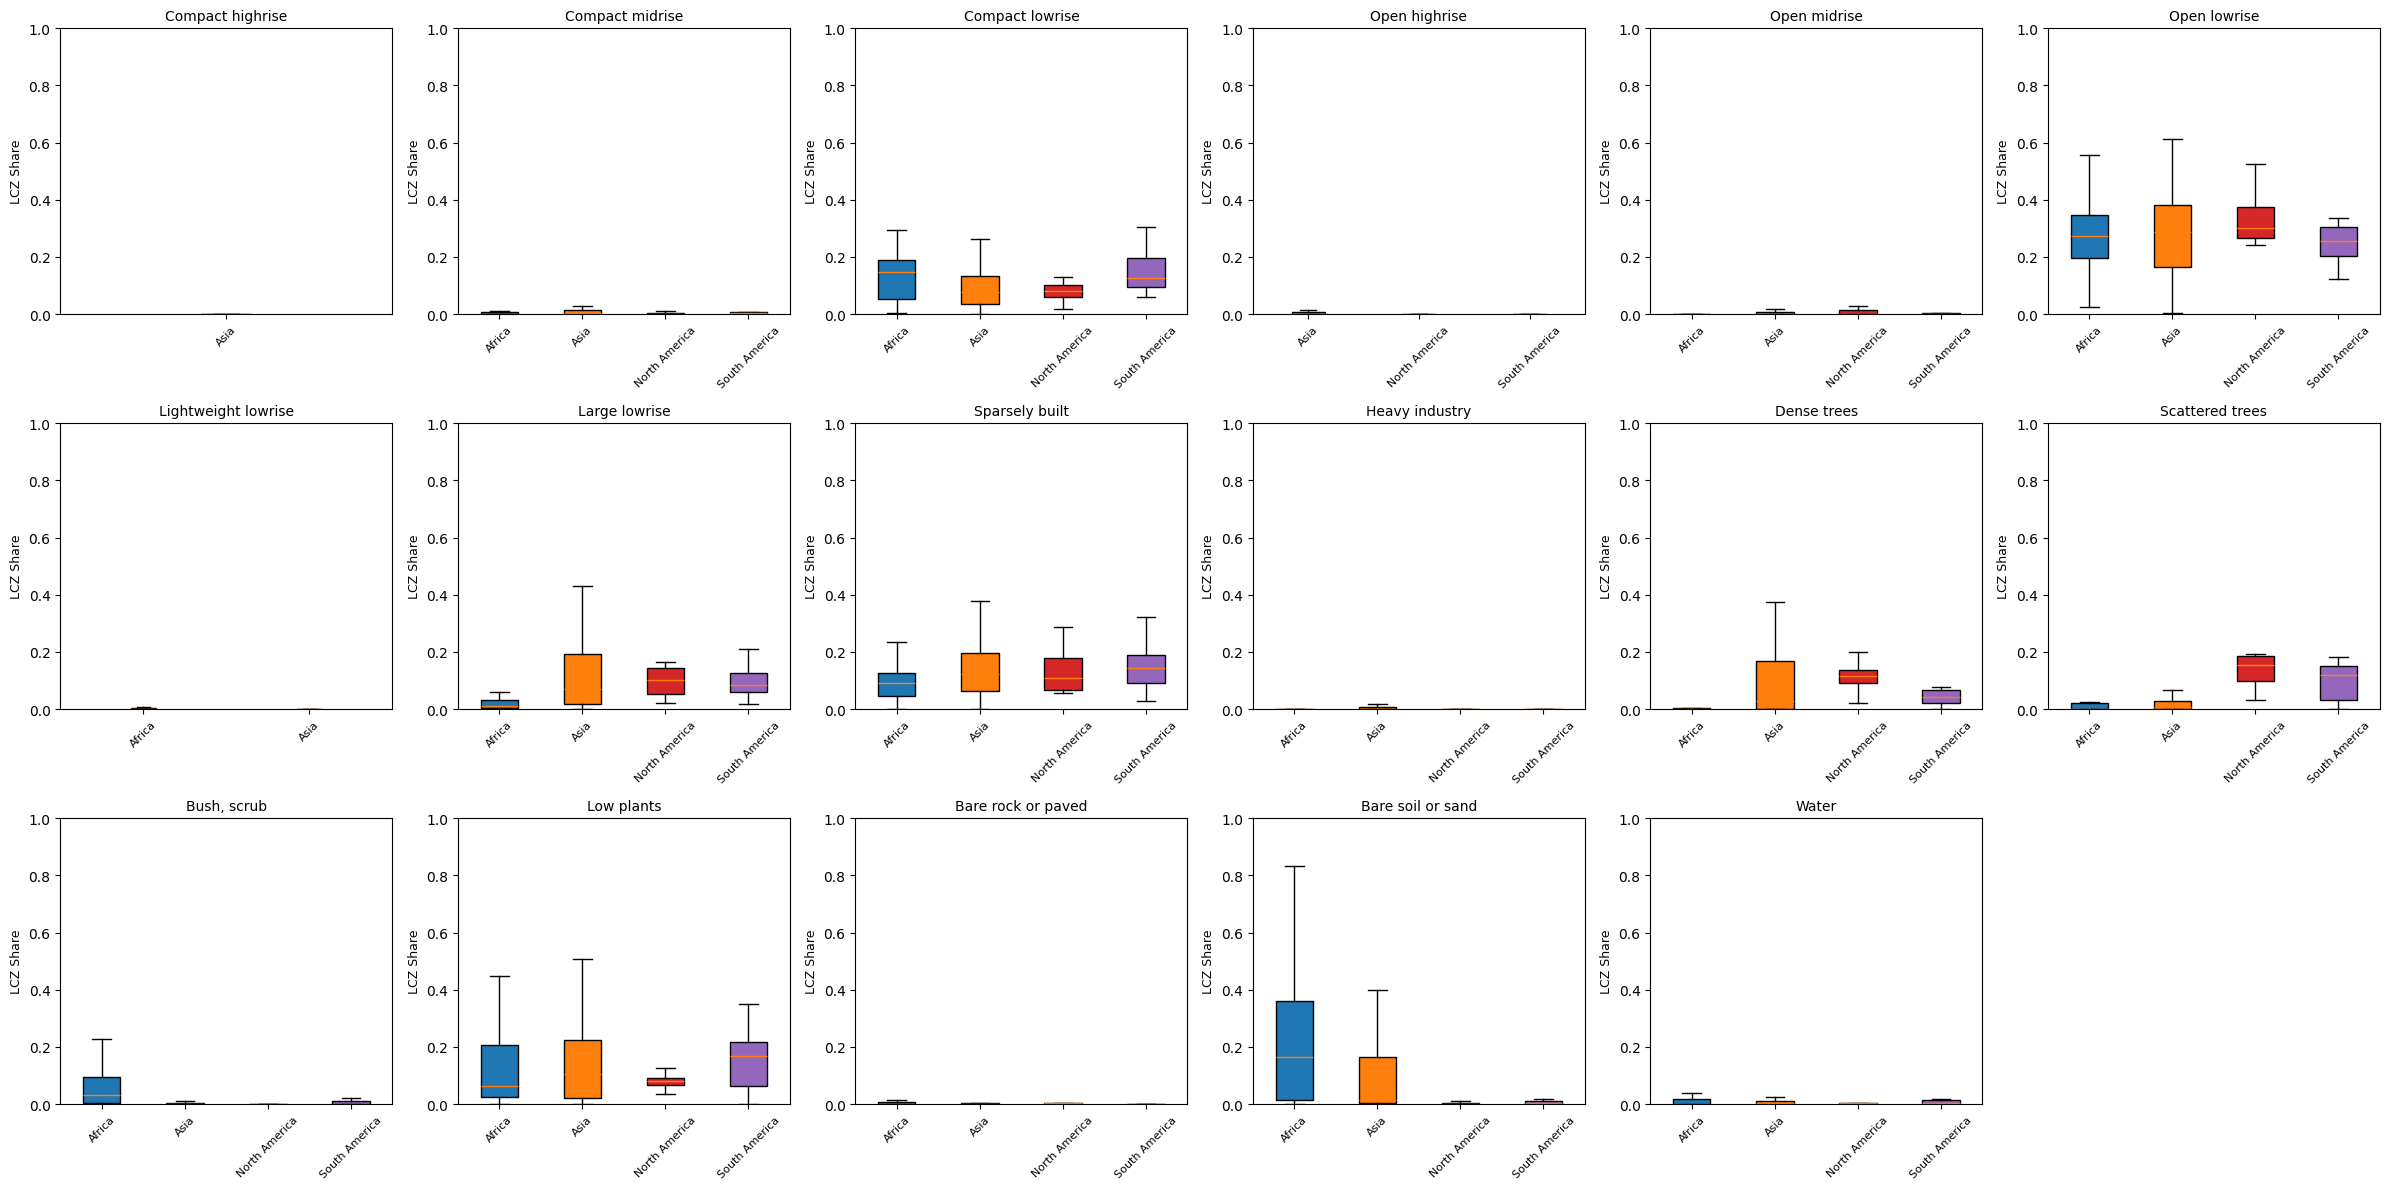

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume merged_data is already loaded and contains:
#  - 'Continent'
#  - 'Mean_2071_2100'
#  - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Filter the data to include only cities with Mean_2071_2100 > 29
high_temp_data = merged_data[merged_data["Mean_2071_2100"] > 29]

# Define LCZ columns and descriptive labels.
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define the continent order and color palette.
continent_order = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'Europe': '#2ca02c',
    'North America': '#d62728',
    'South America': '#9467bd',
    'Oceania': '#8c564b'
}

# Create a grid of subplots for the 17 LCZs (arranged in 3 rows x 6 columns).
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 12))
axes = axes.flatten()

# Loop over each LCZ.
for idx, lcz in enumerate(lcz_columns):
    ax = axes[idx]
    # Drop rows with missing values for this LCZ.
    subset = high_temp_data[['Continent', lcz]].dropna(subset=[lcz])
    
    data_by_continent = []
    labels = []
    colors = []
    
    # Loop through continents in the defined order.
    for cont in continent_order:
        cont_data = subset[subset['Continent'] == cont][lcz].values
        if len(cont_data) > 0:
            data_by_continent.append(cont_data)
            labels.append(cont)
            colors.append(continent_palette.get(cont, 'black'))
    
    # Plot box plots if data exists.
    if data_by_continent:
        bp = ax.boxplot(data_by_continent, patch_artist=True, showfliers=False)
        # Color each box.
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_xticks(range(1, len(labels) + 1))
        ax.set_xticklabels(labels, rotation=45, fontsize=8)
    
    ax.set_title(lcz_labels[lcz], fontsize=10)
    ax.set_ylabel("LCZ Share", fontsize=9)
    ax.set_ylim(0, 1)

# Hide any unused subplot if present.
if len(axes) > 17:
    for ax in axes[17:]:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
from scipy.stats import ttest_ind

# --- Assume merged_data is already loaded and contains:
#      - 'Continent'
#      - 'Mean_2071_2100'
#      - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define LCZ columns and descriptive labels.
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# --- Split the Data into Two Groups Based on "Mean_2071_2100" ---
# Group 1: Cities with Mean_2071_2100 > 29
high_temp = merged_data[merged_data["Mean_2071_2100"] > 29]
# Group 2: Cities with Mean_2071_2100 <= 29
low_temp = merged_data[merged_data["Mean_2071_2100"] <= 29]

# --- Overall Comparison for All Cities ---
overall_results = []

for lcz in lcz_columns:
    # Get LCZ share values (drop missing values) for each group.
    high_values = high_temp[lcz].dropna()
    low_values = low_temp[lcz].dropna()
    
    # Skip the LCZ if one group has no data.
    if len(high_values) == 0 or len(low_values) == 0:
        continue

    # Perform a two-sample t-test (Welch's t-test, which does not assume equal variances).
    t_stat, p_val = ttest_ind(high_values, low_values, equal_var=False, nan_policy='omit')
    
    overall_results.append({
        "LCZ": lcz,
        "LCZ_Description": lcz_labels[lcz],
        "High_N": len(high_values),
        "Low_N": len(low_values),
        "High_Mean": high_values.mean(),
        "Low_Mean": low_values.mean(),
        "T_stat": t_stat,
        "P_value": p_val
    })

overall_df = pd.DataFrame(overall_results)
print("Overall Comparison (All Cities):")
print(overall_df)
# You may also want to export the table:
# overall_df.to_csv("overall_lcz_comparison.csv", index=False)

# --- Comparison by Continent ---
continent_results = []

# Loop over each unique continent in the dataset.
for cont in merged_data["Continent"].unique():
    data_cont = merged_data[merged_data["Continent"] == cont]
    high_cont = data_cont[data_cont["Mean_2071_2100"] > 29]
    low_cont  = data_cont[data_cont["Mean_2071_2100"] <= 29]
    
    for lcz in lcz_columns:
        high_vals = high_cont[lcz].dropna()
        low_vals = low_cont[lcz].dropna()
        
        # Only perform a test if both groups have data.
        if len(high_vals) == 0 or len(low_vals) == 0:
            continue
        
        t_stat, p_val = ttest_ind(high_vals, low_vals, equal_var=False, nan_policy='omit')
        continent_results.append({
            "Continent": cont,
            "LCZ": lcz,
            "LCZ_Description": lcz_labels[lcz],
            "High_N": len(high_vals),
            "Low_N": len(low_vals),
            "High_Mean": high_vals.mean(),
            "Low_Mean": low_vals.mean(),
            "T_stat": t_stat,
            "P_value": p_val
        })

continent_df = pd.DataFrame(continent_results)
print("\nComparison by Continent:")
print(continent_df)
# Optionally export to CSV:
continent_df.to_csv("continent_lcz_comparison.csv", index=False)


Overall Comparison (All Cities):
       LCZ      LCZ_Description  High_N  Low_N  High_Mean  Low_Mean  \
0    LCZ_1     Compact highrise      23    599   0.001009  0.003368   
1    LCZ_2      Compact midrise     120   1079   0.009447  0.018848   
2    LCZ_3      Compact lowrise     217   1278   0.104131  0.067485   
3    LCZ_4        Open highrise     110   1078   0.004582  0.018842   
4    LCZ_5         Open midrise     151   1203   0.005460  0.042595   
5    LCZ_6         Open lowrise     217   1282   0.274676  0.260189   
6    LCZ_7  Lightweight lowrise      29    347   0.004364  0.003189   
7    LCZ_8        Large lowrise     215   1263   0.114349  0.151268   
8    LCZ_9       Sparsely built     217   1278   0.132684  0.104289   
9   LCZ_10       Heavy industry     101    954   0.006653  0.005709   
10  LCZ_11          Dense trees     160   1190   0.091108  0.087312   
11  LCZ_12      Scattered trees     188   1241   0.029578  0.049734   
12  LCZ_13          Bush, scrub     145    5

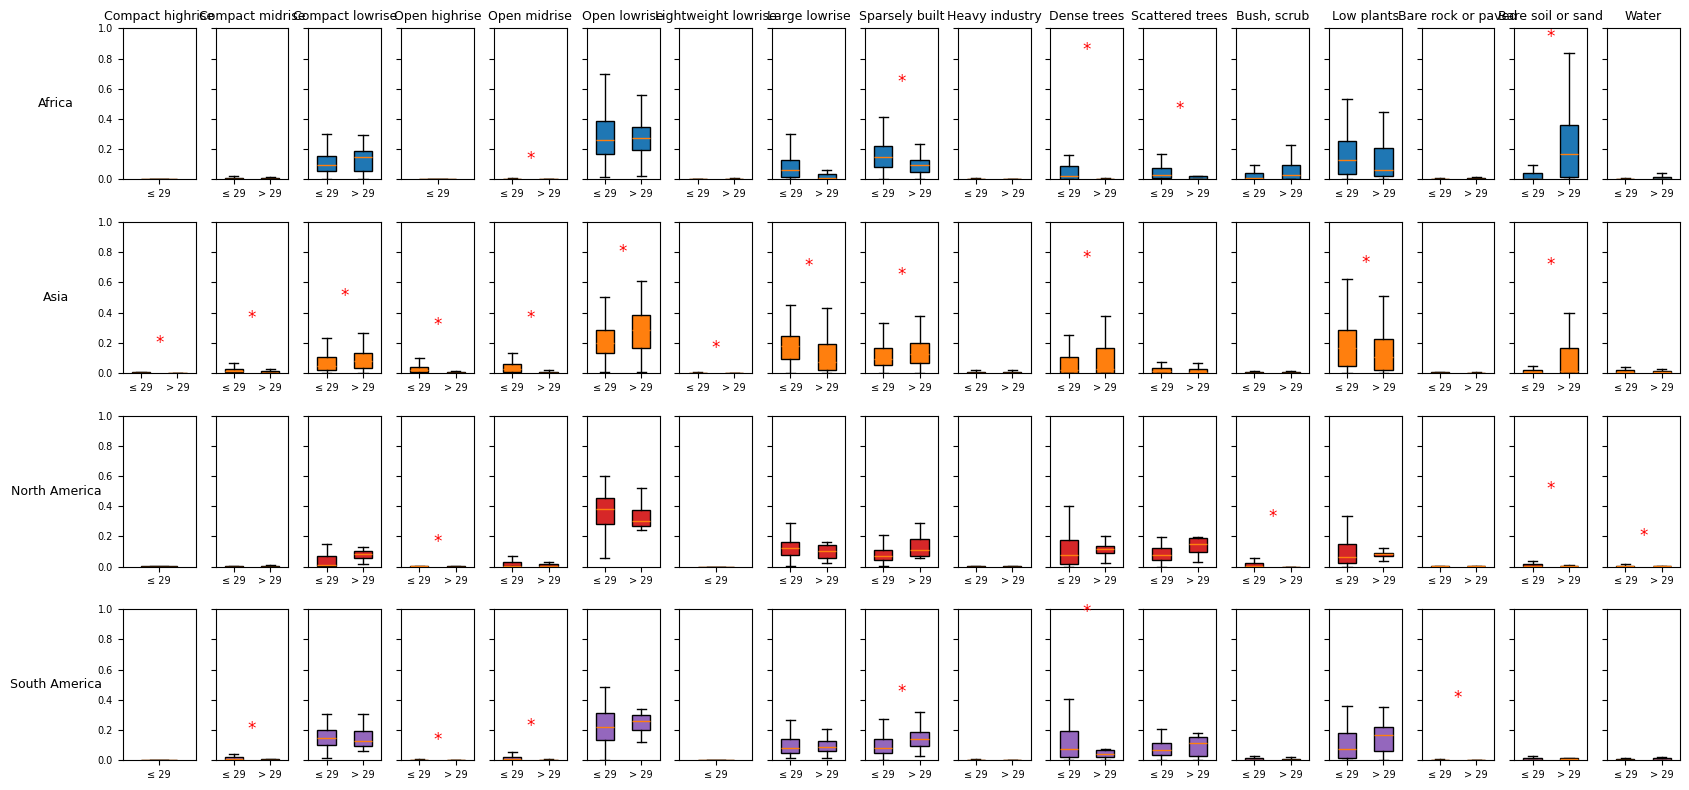

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assume merged_data is already loaded and contains:
#  - 'Continent'
#  - 'Mean_2071_2100'
#  - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define LCZ columns and descriptive labels.
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Define the continent order and corresponding color palette (excluding Europe and Oceania).
continent_order = ['Africa', 'Asia', 'North America', 'South America']
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'North America': '#d62728',
    'South America': '#9467bd'
}

# Set number of rows and columns.
n_rows = len(continent_order)
n_cols = len(lcz_columns)

# Create a grid of subplots with a narrower overall figure.
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(17, 8), sharey=True)

# Loop over each continent (row) and each LCZ (column).
for i, cont in enumerate(continent_order):
    for j, lcz in enumerate(lcz_columns):
        ax = axes[i, j]
        # Subset data for this continent and LCZ (drop missing values)
        cell_data = merged_data[(merged_data['Continent'] == cont) & (merged_data[lcz].notna())]
        if cell_data.empty:
            ax.axis('off')
            continue

        # Split data into two groups: ≤ 29 and > 29 for "Mean_2071_2100".
        group_below = cell_data[cell_data["Mean_2071_2100"] <= 29][lcz]
        group_above = cell_data[cell_data["Mean_2071_2100"] > 29][lcz]

        data_to_plot = []
        positions = []
        group_labels = []
        if not group_below.empty:
            data_to_plot.append(group_below.values)
            group_labels.append("≤ 29")
            positions.append(1)
        if not group_above.empty:
            data_to_plot.append(group_above.values)
            group_labels.append("> 29")
            positions.append(2)
        if len(data_to_plot) == 0:
            ax.axis('off')
            continue

        # Plot thinner box plots (width=0.15)
        bp = ax.boxplot(data_to_plot, positions=positions, patch_artist=True, widths=0.5, showfliers=False)
        box_color = continent_palette.get(cont, 'black')
        for patch in bp['boxes']:
            patch.set_facecolor(box_color)

        ax.set_xticks(positions)
        ax.set_xticklabels(group_labels, fontsize=7)
        ax.set_ylim(0, 1)
        ax.tick_params(axis='y', labelsize=7)

        # If both groups exist, perform a t-test and annotate significance.
        if len(data_to_plot) == 2:
            t_stat, p_val = ttest_ind(group_below, group_above, equal_var=False, nan_policy='omit')
            if p_val < 0.05:
                max_val = max(np.max(group_below), np.max(group_above))
                ax.text(1.5, max_val + 0.05, "*", ha='center', va='bottom', fontsize=12, color='red')

        # Set column title for the top row.
        if i == 0:
            ax.set_title(lcz_labels[lcz], fontsize=9)
        # Label the first column with the continent name.
        if j == 0:
            ax.set_ylabel(cont, fontsize=9, rotation=0, labelpad=30, va='center')

plt.tight_layout()
plt.show()


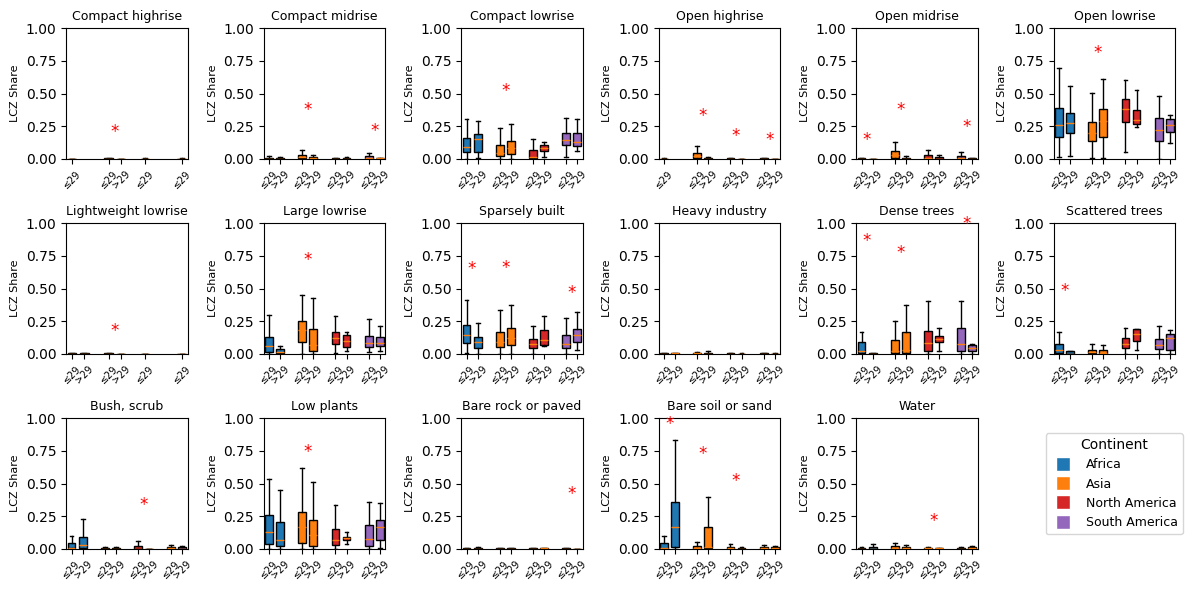

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assume merged_data is already loaded and contains:
#  - 'Continent'
#  - 'Mean_2071_2100'
#  - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define LCZ columns and descriptive labels.
lcz_columns = [f"LCZ_{i}" for i in range(1, 18)]
lcz_labels = {
    "LCZ_1": "Compact highrise",
    "LCZ_2": "Compact midrise",
    "LCZ_3": "Compact lowrise",
    "LCZ_4": "Open highrise",
    "LCZ_5": "Open midrise",
    "LCZ_6": "Open lowrise",
    "LCZ_7": "Lightweight lowrise",
    "LCZ_8": "Large lowrise",
    "LCZ_9": "Sparsely built",
    "LCZ_10": "Heavy industry",
    "LCZ_11": "Dense trees",
    "LCZ_12": "Scattered trees",
    "LCZ_13": "Bush, scrub",
    "LCZ_14": "Low plants",
    "LCZ_15": "Bare rock or paved",
    "LCZ_16": "Bare soil or sand",
    "LCZ_17": "Water"
}

# Only include these continents.
continent_order = ['Africa', 'Asia', 'North America', 'South America']
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'North America': '#d62728',
    'South America': '#9467bd'
}

# For each continent, we define fixed positions for its two groups:
# Group for cities with Mean_2071_2100 ≤29 and >29.
pos_dict = {
    'Africa': (1, 2),
    'Asia': (4, 5),
    'North America': (7, 8),
    'South America': (10, 11)
}

# Create a grid of 17 subfigures arranged in 3 rows x 6 columns (the 18th is reserved for legend).
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 6)) #10,18
axes = axes.flatten()

# Loop over each LCZ (each subfigure)
for idx, lcz in enumerate(lcz_columns):
    ax = axes[idx]
    data_to_plot = []    # list to hold arrays to be box-plotted
    plot_positions = []  # corresponding x-axis positions
    tick_labels = []     # labels for the x-axis ticks
    significance_annotations = []  # to record significance for each continent

    # Loop over each continent.
    for cont in continent_order:
        # Subset for this LCZ and continent.
        cell_data = merged_data[(merged_data['Continent'] == cont) & (merged_data[lcz].notna())]
        if cell_data.empty:
            continue

        # Split into two groups based on Mean_2071_2100.
        group_below = cell_data[cell_data["Mean_2071_2100"] <= 29][lcz].dropna()
        group_above = cell_data[cell_data["Mean_2071_2100"] > 29][lcz].dropna()

        base_pos = pos_dict[cont]
        # Append group for ≤29 if available.
        if not group_below.empty:
            data_to_plot.append(group_below.values)
            plot_positions.append(base_pos[0])
            tick_labels.append(f"≤29")
        # Append group for >29 if available.
        if not group_above.empty:
            data_to_plot.append(group_above.values)
            plot_positions.append(base_pos[1])
            tick_labels.append(f">29")
        # If both groups exist for this continent, test for significance.
        if (not group_below.empty) and (not group_above.empty):
            t_stat, p_val = ttest_ind(group_below, group_above, equal_var=False, nan_policy='omit')
            if p_val < 0.05:
                mid_pos = np.mean(base_pos)
                max_val = max(np.max(group_below), np.max(group_above))
                significance_annotations.append((mid_pos, max_val))
    
    # Plot all box plots in this LCZ subfigure if any data is available.
    if data_to_plot:
        bp = ax.boxplot(data_to_plot, positions=plot_positions, widths=0.7,
                        patch_artist=True, showfliers=False)
        # Color the boxes according to continent.
        for i_box, pos in enumerate(plot_positions):
            box_color = None
            for cont in continent_order:
                if pos in pos_dict[cont]:
                    box_color = continent_palette[cont]
                    break
            bp['boxes'][i_box].set_facecolor(box_color)
    
    ax.set_xticks(plot_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=7)
    ax.set_ylim(0, 1)
    ax.set_title(lcz_labels[lcz], fontsize=9)
    ax.set_ylabel("LCZ Share", fontsize=8)
    
    # Annotate significance stars for each continent (if any).
    for mid_pos, max_val in significance_annotations:
        ax.text(mid_pos, max_val + 0.05, "*", ha='center', va='bottom', fontsize=12, color='red')

# Use the last subplot (axes[17]) for legend.
legend_ax = axes[17]
legend_ax.axis('off')
from matplotlib.lines import Line2D
legend_handles = []
for cont in continent_order:
    legend_handles.append(Line2D([0], [0], marker='s', color='w',
                                  markerfacecolor=continent_palette[cont],
                                  markersize=10, label=cont))
legend_ax.legend(handles=legend_handles, title="Continent", loc='center', fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()


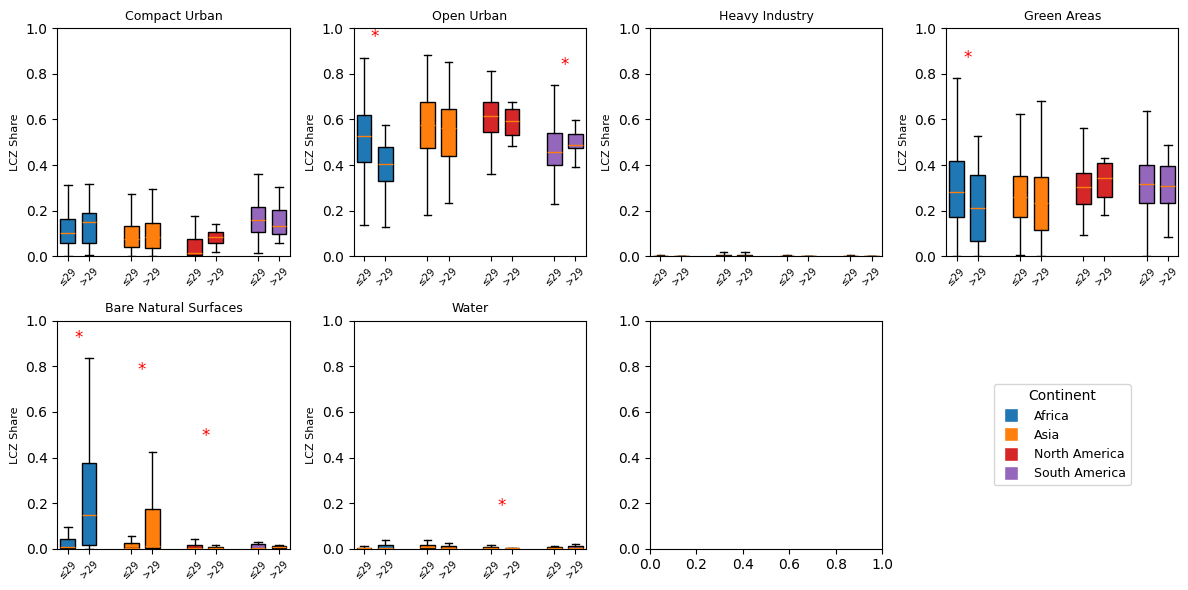

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assume merged_data is already loaded and contains:
#  - 'Continent'
#  - 'Mean_2071_2100'
#  - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define new grouping for LCZ classes.
group_mapping = {
    "Compact Urban": ["LCZ_1", "LCZ_2", "LCZ_3", "LCZ_7"],
    "Open Urban": ["LCZ_4", "LCZ_5", "LCZ_6", "LCZ_9", "LCZ_8"],
    "Heavy Industry": ["LCZ_10"],
    "Green Areas": ["LCZ_11", "LCZ_12", "LCZ_13", "LCZ_14"],
    "Bare Natural Surfaces": ["LCZ_15", "LCZ_16"],
    "Water": ["LCZ_17"]
}

# Only include these continents.
continent_order = ['Africa', 'Asia', 'North America', 'South America']
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'North America': '#d62728',
    'South America': '#9467bd'
}

# For each continent, define fixed positions for its two groups:
# Group for cities with Mean_2071_2100 ≤29 and >29.
pos_dict = {
    'Africa': (1, 2),
    'Asia': (4, 5),
    'North America': (7, 8),
    'South America': (10, 11)
}

# Create a grid of 7 subfigures arranged in 2 rows x 4 columns (8 subplots total, with the last reserved for the legend).
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
axes = axes.flatten()

# Loop over each LCZ group.
for idx, (group_name, lcz_list) in enumerate(group_mapping.items()):
    ax = axes[idx]
    data_to_plot = []    # List to hold arrays for box plots.
    plot_positions = []  # Corresponding x-axis positions.
    tick_labels = []     # Labels for the x-axis ticks.
    significance_annotations = []  # Record significance for each continent.
    
    # Loop over each continent.
    for cont in continent_order:
        # Subset for this group and continent; include rows with at least one non-NA value.
        cell_data = merged_data[(merged_data['Continent'] == cont) & (merged_data[lcz_list].notna().any(axis=1))]
        if cell_data.empty:
            continue
        
        # Compute the group share as the sum of the LCZ shares in this group.
        group_share = cell_data[lcz_list].sum(axis=1)
        
        # Split into two groups based on Mean_2071_2100.
        group_below = group_share[cell_data["Mean_2071_2100"] <= 29].dropna()
        group_above = group_share[cell_data["Mean_2071_2100"] > 29].dropna()
        
        base_pos = pos_dict[cont]
        # Append group for ≤29 if available.
        if not group_below.empty:
            data_to_plot.append(group_below.values)
            plot_positions.append(base_pos[0])
            tick_labels.append("≤29")
        # Append group for >29 if available.
        if not group_above.empty:
            data_to_plot.append(group_above.values)
            plot_positions.append(base_pos[1])
            tick_labels.append(">29")
        
        # If both groups exist for this continent, test for significance.
        if (not group_below.empty) and (not group_above.empty):
            t_stat, p_val = ttest_ind(group_below, group_above, equal_var=False, nan_policy='omit')
            if p_val < 0.05:
                mid_pos = np.mean(base_pos)
                max_val = max(np.max(group_below), np.max(group_above))
                significance_annotations.append((mid_pos, max_val))
    
    # Plot all box plots for this LCZ group if any data is available.
    if data_to_plot:
        bp = ax.boxplot(data_to_plot, positions=plot_positions, widths=0.7,
                        patch_artist=True, showfliers=False)
        # Color the boxes according to continent.
        for i_box, pos in enumerate(plot_positions):
            box_color = None
            for cont in continent_order:
                if pos in pos_dict[cont]:
                    box_color = continent_palette[cont]
                    break
            bp['boxes'][i_box].set_facecolor(box_color)
    
    ax.set_xticks(plot_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=7)
    ax.set_ylim(0, 1)
    ax.set_title(group_name, fontsize=9)
    ax.set_ylabel("LCZ Share", fontsize=8)
    
    # Annotate significance stars for each continent (if any).
    for mid_pos, max_val in significance_annotations:
        ax.text(mid_pos, max_val + 0.05, "*", ha='center', va='bottom', fontsize=12, color='red')

# Use the last subplot (axes[7]) for the legend.
legend_ax = axes[7]
legend_ax.axis('off')
from matplotlib.lines import Line2D
legend_handles = []
for cont in continent_order:
    legend_handles.append(Line2D([0], [0], marker='s', color='w',
                                  markerfacecolor=continent_palette[cont],
                                  markersize=10, label=cont))
legend_ax.legend(handles=legend_handles, title="Continent", loc='center', fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()


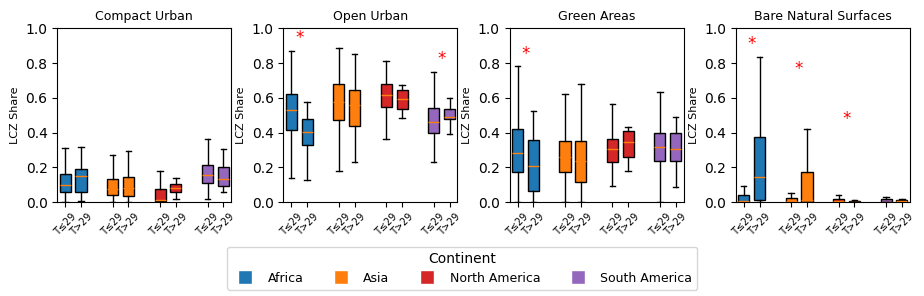

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assume merged_data is already loaded and contains:
#  - 'Continent'
#  - 'Mean_2071_2100'
#  - LCZ share columns: 'LCZ_1', 'LCZ_2', ..., 'LCZ_17'

# Define new grouping for LCZ classes.
group_mapping = {
    "Compact Urban": ["LCZ_1", "LCZ_2", "LCZ_3", "LCZ_7"],
    "Open Urban": ["LCZ_4", "LCZ_5", "LCZ_6", "LCZ_9", "LCZ_8"],
    "Green Areas": ["LCZ_11", "LCZ_12", "LCZ_13", "LCZ_14"],
    "Bare Natural Surfaces": ["LCZ_15", "LCZ_16"]
}

# Only include these continents.
continent_order = ['Africa', 'Asia', 'North America', 'South America']
continent_palette = {
    'Africa': '#1f77b4',
    'Asia': '#ff7f0e',
    'North America': '#d62728',
    'South America': '#9467bd'
}

# For each continent, define fixed positions for its two groups:
# Group for cities with Mean_2071_2100 ≤29 and >29.
pos_dict = {
    'Africa': (1, 2),
    'Asia': (4, 5),
    'North America': (7, 8),
    'South America': (10, 11)
}

# Create a grid of 2x2 subplots for the LCZ groups.
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(11, 3)) #plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axes = axes.flatten()

# Loop over each LCZ group.
for idx, (group_name, lcz_list) in enumerate(group_mapping.items()):
    ax = axes[idx]
    data_to_plot = []    # List to hold arrays for box plots.
    plot_positions = []  # Corresponding x-axis positions.
    tick_labels = []     # Labels for the x-axis ticks.
    significance_annotations = []  # Record significance for each continent.
    
    # Loop over each continent.
    for cont in continent_order:
        # Subset for this group and continent; include rows with at least one non-NA value.
        cell_data = merged_data[(merged_data['Continent'] == cont) & (merged_data[lcz_list].notna().any(axis=1))]
        if cell_data.empty:
            continue
        
        # Compute the group share as the sum of the LCZ shares in this group.
        group_share = cell_data[lcz_list].sum(axis=1)
        
        # Split into two groups based on Mean_2071_2100.
        group_below = group_share[cell_data["Mean_2071_2100"] <= 29].dropna()
        group_above = group_share[cell_data["Mean_2071_2100"] > 29].dropna()
        
        base_pos = pos_dict[cont]
        # Append group for ≤29 if available.
        if not group_below.empty:
            data_to_plot.append(group_below.values)
            plot_positions.append(base_pos[0])
            tick_labels.append("T≤29")
        # Append group for >29 if available.
        if not group_above.empty:
            data_to_plot.append(group_above.values)
            plot_positions.append(base_pos[1])
            tick_labels.append("T>29")
        
        # If both groups exist for this continent, test for significance.
        if (not group_below.empty) and (not group_above.empty):
            t_stat, p_val = ttest_ind(group_below, group_above, equal_var=False, nan_policy='omit')
            if p_val < 0.05:
                mid_pos = np.mean(base_pos)
                max_val = max(np.max(group_below), np.max(group_above))
                significance_annotations.append((mid_pos, max_val))
    
    # Plot all box plots for this LCZ group if any data is available.
    if data_to_plot:
        bp = ax.boxplot(data_to_plot, positions=plot_positions, widths=0.7,
                        patch_artist=True, showfliers=False)
        # Color the boxes according to continent.
        for i_box, pos in enumerate(plot_positions):
            box_color = None
            for cont in continent_order:
                if pos in pos_dict[cont]:
                    box_color = continent_palette[cont]
                    break
            bp['boxes'][i_box].set_facecolor(box_color)
    
    ax.set_xticks(plot_positions)
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=7)
    ax.set_ylim(0, 1)
    ax.set_title(group_name, fontsize=9)
    ax.set_ylabel("LCZ Share", fontsize=8)
    
    # Annotate significance stars for each continent (if any).
    for mid_pos, max_val in significance_annotations:
        ax.text(mid_pos, max_val + 0.02, "*", ha='center', va='bottom', fontsize=12, color='red')

# Create a legend using the figure's legend function.
from matplotlib.lines import Line2D
legend_handles = []
for cont in continent_order:
    legend_handles.append(Line2D([0], [0], marker='s', color='w',
                                  markerfacecolor=continent_palette[cont],
                                  markersize=10, label=cont))

# Place the legend centered below all subplots.
fig.legend(handles=legend_handles, title="Continent", loc='lower center', ncol=len(continent_order),
           fontsize=9, title_fontsize=10)

# Adjust the layout to provide space at the bottom for the legend.
plt.subplots_adjust(bottom=0.3, wspace=0.3, hspace=0.4)
plt.show()


In [ ]:
# =======================
# QUANTITATIVE INSIGHTS (Median-basiert)
# =======================

import pandas as pd
import numpy as np

md = merged_data.copy()

# Group Shares
md['share_compact']   = md[group_mapping['Compact Urban']].sum(axis=1)
md['share_green']     = md[group_mapping['Green Areas']].sum(axis=1)
md['share_bare_nat']  = md[group_mapping['Bare Natural Surfaces']].sum(axis=1)

# Low-Plants separat (LCZ_14); falls nicht vorhanden, 0 setzen
md['share_low_plants'] = md['LCZ_14'] if 'LCZ_14' in md.columns else 0.0

# Exceedance-Flag
md['exceeds'] = md['Mean_2071_2100'] > 29

# (2) Kontinentspezifische MEDIAN-Schwellen bestimmen
thr = (
    md.groupby('Continent')
      .apply(lambda d: pd.Series({
          'thr_bare_med':     d['share_bare_nat'].median(),
          'thr_green_med':    d['share_green'].median(),
          'thr_lowplant_med': d['share_low_plants'].median(),
          'thr_compact_med':  d['share_compact'].median(),
      }))
      .reset_index()
)

md = md.merge(thr, on='Continent', how='left')

# (3) Traits per Median definieren
# Konvention: "hoch" = ">" Median, "niedrig" = "<= Median" (bindet Gleichstände auf "niedrig")
md['trait_bare_hi']      = md['share_bare_nat']     >  md['thr_bare_med']
md['trait_green_lo']     = md['share_green']        <= md['thr_green_med']
md['trait_lowplant_lo']  = md['share_low_plants']   <= md['thr_lowplant_med']
md['trait_compact_hi']   = md['share_compact']      >  md['thr_compact_med']  # optional

# (4) Prozentanteile + (optional) Odds Ratios vs. Nicht-Exceedern
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan, np.nan)
    p = k / n
    denom = 1 + (z**2)/n
    center = (p + (z**2)/(2*n)) / denom
    half = z * np.sqrt(p*(1-p)/n + (z**2)/(4*n**2)) / denom
    return p*100, (center-half)*100, (center+half)*100

traits = {
    'trait_bare_hi':     'Bare natural > Kontinents-Median',
    'trait_green_lo':    'Grünanteil ≤ Kontinents-Median',
    'trait_lowplant_lo': 'Low-Plants ≤ Kontinents-Median',
    'trait_compact_hi':  'Kompakt urban > Kontinents-Median'
}

regions = ['All'] + continent_order
rows = []

for region in regions:
    sub = md if region == 'All' else md[md['Continent'] == region]
    ex  = sub[sub['exceeds']]
    non = sub[~sub['exceeds']]

    for col, label in traits.items():
        k, n = int(ex[col].sum()), len(ex)
        p, lo, hi = wilson_ci(k, n)

        # Vergleich zu Nicht-Exceedern + einfache Odds Ratio
        k_non, n_non = int(non[col].sum()), len(non)
        a, b = k,     n - k
        c, d = k_non, n_non - k_non
        OR = (a*d)/(b*c) if (b > 0 and c > 0) else np.nan

        rows.append({
            'Region'                : region,
            'N_exceeders'          : n,
            'Trait'                : label,
            'k_exceeders'          : k,
            'Share_exceeders_%'    : None if np.isnan(p) else round(p, 1),
            'CI95'                 : None if np.isnan(p) else f"[{lo:.1f}, {hi:.1f}]",
            'Share_nonexceeders_%' : None if n_non == 0 else round(100 * c / n_non, 1),
            'OR_exceed_vs_non'     : None if np.isnan(OR) else round(OR, 2),
        })

summary = pd.DataFrame(rows)

# Kompakte Konsolenansicht
def show_region(df, region):
    block = (df[df['Region'] == region]
             .loc[:, ['Trait','Share_exceeders_%','CI95','Share_nonexceeders_%','OR_exceed_vs_non']]
             .sort_values('Trait'))
    print(f"\n=== {region} ===")
    print(block.to_string(index=False))

print(f"\nGesamtzahl Exceeders (MAT>29): {int(md['exceeds'].sum())}")
for r in regions:
    show_region(summary, r)

# (Optional) LaTeX-Tabelle nur mit Anteilen der Exceeders
latex_table = (summary
               .pivot(index='Trait', columns='Region', values='Share_exceeders_%')
               .to_latex(float_format=lambda x: f"{x:.1f}" if pd.notnull(x) else ""))
print("\nLaTeX-Tabelle (Anteile Exceeders in %):\n")
print(latex_table)

# (Optional) Ein-Satz-Output (global)
def get_pct(region, trait_key):
    row = summary[(summary['Region']==region) & (summary['Trait']==traits[trait_key])]
    return None if row.empty else row['Share_exceeders_%'].iloc[0]

p_bare  = get_pct('All', 'trait_bare_hi')
p_green = get_pct('All', 'trait_green_lo')
p_lowpl = get_pct('All', 'trait_lowplant_lo')





Gesamtzahl Exceeders (MAT>29): 217

=== All ===
                            Trait  Share_exceeders_%         CI95  Share_nonexceeders_%  OR_exceed_vs_non
 Bare natural > Kontinents-Median               61.3 [54.7, 67.5]                  45.2              1.92
   Grünanteil ≤ Kontinents-Median               57.6 [51.0, 64.0]                  46.0              1.60
Kompakt urban > Kontinents-Median               55.3 [48.6, 61.8]                  46.2              1.44
   Low-Plants ≤ Kontinents-Median               58.1 [51.4, 64.4]                  45.3              1.67

=== Africa ===
                            Trait  Share_exceeders_%         CI95  Share_nonexceeders_%  OR_exceed_vs_non
 Bare natural > Kontinents-Median               80.8 [62.1, 91.5]                  44.4              5.27
   Grünanteil ≤ Kontinents-Median               61.5 [42.5, 77.6]                  47.9              1.74
Kompakt urban > Kontinents-Median               69.2 [50.0, 83.5]                  46.5

/var/folders/p0/6j2q4pb14hb28fbm50jjb7cc0000gn/T/ipykernel_37091/2748214037.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  md.groupby('Continent')
